In [ ]:
!pip install qutip --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 31.3 MB/s eta 0:00:00


In [ ]:
!pip install quocs-lib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for quocs-lib: filename=quocs_lib-0.0.66-py3-none-any.whl size=127355 sha256=6f348cedbb1f638b9e6639711236db610b220c51a1aac7a6dfbddb9b69e5e8e5
  Stored in directory: /root/.cache/pip/wheels/ed/3b/2c/23074a47ae0609fb01e0c39e97c613324117de33c3748fd663
Successfully built quocs-lib


In [ ]:
%%writefile opt_dictionary.json
{
  "optimization_client_name": "HybridNV_Resonator_dCRAB_Chebyshev_NoScaling",
  "optimization_direction": "minimization",
  "create_logfile": true,
  "console_info": true,

  "algorithm_settings": {
    "algorithm_name": "dCRAB",

    "super_iteration_number": 8,
    "max_eval_total": 2500,

    "FoM_goal": 1e-5,

    "random_number_generator": {
      "seed_number": 1234
    },

    "dsm_settings": {
      "general_settings": {
        "dsm_algorithm_name": "NelderMead",
        "is_adaptive": false
      },
      "stopping_criteria": {
        "max_eval": 80,
        "xatol": 1e-6,
        "fatol": 1e-7
      }
    }
  },

  "pulses": [
    {
      "pulse_name": "drive_a",
      "upper_limit": 0.10,
      "lower_limit": -0.10,
      "bins_number": 80,
      "time_name": "t",

      "amplitude_variation": 0.03,
      "shrink_ampl_lim": true,

      "basis": {
        "basis_name": "Chebyshev",
        "basis_vector_number": 4,
        "random_super_parameter_distribution": {
          "distribution_name": "Uniform",
          "lower_limit": 1.0,
          "upper_limit": 5.0
        }
      },

      "initial_guess": {
        "function_type": "lambda_function",
        "lambda_function": "lambda t: 0.02*np.cos(2*np.arccos(-1 + 2*t/1.0))"
      },

      "shaping_options": [
        "add_initial_guess",
        "add_base_pulse",
        "add_new_update_pulse",
        "limit_pulse"
      ]
    },

    {
      "pulse_name": "drive_b",
      "upper_limit": 0.10,
      "lower_limit": -0.10,
      "bins_number": 80,
      "time_name": "t",

      "amplitude_variation": 0.03,
      "shrink_ampl_lim": true,

      "basis": {
        "basis_name": "Chebyshev",
        "basis_vector_number": 4,
        "random_super_parameter_distribution": {
          "distribution_name": "Uniform",
          "lower_limit": 1.0,
          "upper_limit": 5.0
        }
      },

      "initial_guess": {
        "function_type": "lambda_function",
        "lambda_function": "lambda t: 0.02*np.cos(3*np.arccos(-1 + 2*t/1.0))"
      },

      "shaping_options": [
        "add_initial_guess",
        "add_base_pulse",
        "add_new_update_pulse",
        "limit_pulse"
      ]
    }
  ],

  "parameters": [],

  "times": [
    {
      "time_name": "t",
      "initial_value": 1.0
    }
  ]
}


Overwriting opt_dictionary.json


In [ ]:
%%writefile fom_hybrid.py
import numpy as np
import qutip as qt
from quocslib.utils.AbstractFoM import AbstractFoM


# 1. UNIT CONVERSION

two_pi = 2*np.pi

def MHz_to_radns(MHz):
    return two_pi * MHz * 1e-3

def per_us_to_per_ns(rate):
    return rate * 1e-3



omega_a  = MHz_to_radns(2000.0)
omega_b  = MHz_to_radns(2000.0)
omega_eg = MHz_to_radns(2000.0)

omega_ge1 = MHz_to_radns(2000.0)
omega_ge2 = MHz_to_radns(2000.0)

omega_gu1 = MHz_to_radns(2800.0)
omega_gu2 = MHz_to_radns(2800.0)

g_a = MHz_to_radns(260.0)
g_b = MHz_to_radns(260.0)
g1  = MHz_to_radns(7.0)
g2  = MHz_to_radns(7.0)

# Detuning
delta_a = omega_a - omega_eg
delta_b = omega_b - omega_eg
delta1_ge = omega_a - omega_ge1
delta1_gu = omega_a - omega_gu1
delta2_ge = omega_b - omega_ge2
delta2_gu = omega_b - omega_gu2

# Collapse rates
kappa     = per_us_to_per_ns(1/20)
gamma_q   = per_us_to_per_ns(1/20)
gamma_phi = per_us_to_per_ns(1/200)


# 2. STATIC OPERATORS
def tensor_op(*ops):
    return qt.tensor(*ops)

# Resonators
a = tensor_op(qt.destroy(2), qt.qeye(2), qt.qeye(2), qt.qeye(3), qt.qeye(3))
b = tensor_op(qt.qeye(2), qt.destroy(2), qt.qeye(2), qt.qeye(3), qt.qeye(3))

# Qubit operators
sigma_plus  = tensor_op(qt.qeye(2), qt.qeye(2), qt.sigmap(), qt.qeye(3), qt.qeye(3))
sigma_minus = tensor_op(qt.qeye(2), qt.qeye(2), qt.sigmam(), qt.qeye(3), qt.qeye(3))

# NV operators
def S_op(level, i, j, idx):
    ops = [qt.qeye(2), qt.qeye(2), qt.qeye(2), qt.qeye(level), qt.qeye(level)]
    ops[idx] = qt.basis(level, i) * qt.basis(level, j).dag()
    return tensor_op(*ops)

S1_ge_plus  = S_op(3,1,0,3)
S1_ge_minus = S_op(3,0,1,3)
S1_gu_plus  = S_op(3,2,0,3)
S1_gu_minus = S_op(3,0,2,3)

S2_ge_plus  = S_op(3,1,0,4)
S2_ge_minus = S_op(3,0,1,4)
S2_gu_plus  = S_op(3,2,0,4)
S2_gu_minus = S_op(3,0,2,4)

# Collapse operators
c_ops_static = [
    np.sqrt(kappa) * a,
    np.sqrt(kappa) * b,
    np.sqrt(gamma_q) * sigma_minus,
    np.sqrt(gamma_phi) * (sigma_plus * sigma_minus)
]

# Initial state
psi0 = tensor_op(
    qt.basis(2,0), qt.basis(2,0), qt.basis(2,0),
    qt.basis(3,0), qt.basis(3,0)
)


# 3. TARGET STATE ρ_T4 (ENTANGLED + WHITE NOISE)
λ = 0.90
g1q = qt.basis(3,0); e1q = qt.basis(3,1)
g2q = qt.basis(3,0); e2q = qt.basis(3,1)

NV_gg = qt.tensor(g1q, g2q)
NV_ee = qt.tensor(e1q, e2q)
NV_ge = qt.tensor(g1q, e2q)
NV_eg = qt.tensor(e1q, g2q)

rho_white_NV = (NV_gg*NV_gg.dag() + NV_ge*NV_ge.dag() +
                 NV_eg*NV_eg.dag() + NV_ee*NV_ee.dag()) / 4.0

NV_ent = (NV_gg + NV_ee).unit()
rho_T3_NV = NV_ent * NV_ent.dag()

proj_a = qt.basis(2,0) * qt.basis(2,0).dag()
proj_b = qt.basis(2,0) * qt.basis(2,0).dag()
proj_q = qt.basis(2,0) * qt.basis(2,0).dag()

rho_T3 = qt.tensor(proj_a, proj_b, proj_q, rho_T3_NV)
rho_T4 = λ * rho_T3 + (1-λ)*qt.tensor(proj_a, proj_b, proj_q, rho_white_NV)


# 4. HYBRID FoM CLASS UNTUK QUOCS
class HybridFoM(AbstractFoM):

    def __init__(self, args_dict=None):
        self.psi0 = psi0
        self.rho_target = rho_T4
        self.c_ops = c_ops_static

        # physics constants
        self.g_a = g_a; self.g_b = g_b; self.g1 = g1; self.g2 = g2
        self.da = delta_a; self.db = delta_b
        self.d1ge = delta1_ge; self.d1gu = delta1_gu
        self.d2ge = delta2_ge; self.d2gu = delta2_gu

        # operator references
        self._ops = [
            (g_a * a * sigma_plus,        self.da,  +1),
            (g_a * a.dag() * sigma_minus, self.da,  -1),
            (g_b * b * sigma_plus,        self.db,  +1),
            (g_b * b.dag() * sigma_minus, self.db,  -1),

            (g1 * a * S1_ge_plus,         self.d1ge, +1),
            (g1 * a.dag()*S1_ge_minus,    self.d1ge, -1),
            (g1 * a * S1_gu_plus,         self.d1gu, +1),
            (g1 * a.dag()*S1_gu_minus,    self.d1gu, -1),

            (g2 * b * S2_ge_plus,         self.d2ge, +1),
            (g2 * b.dag()*S2_ge_minus,    self.d2ge, -1),
            (g2 * b * S2_gu_plus,         self.d2gu, +1),
            (g2 * b.dag()*S2_gu_minus,    self.d2gu, -1),
        ]

        self.n_points = args_dict.get("n_points", 1500) if args_dict else 1500


    # MAIN: Compute FoM
    def get_FoM(self, pulses=[], parameters=[], timegrids=[]):

        pulse = np.array(pulses[0])
        tgrid = np.array(timegrids[0])
        T = tgrid[-1]

        # build fine grid for QuTiP
        times = np.linspace(0, T, self.n_points)
        pulse_interp = np.interp(times, tgrid, pulse)

        # Build H(t) as list of [operator, coeff_array]
        H_t = []

        # all coupling operators
        for (op, det, sgn) in self._ops:
            H_t.append([op, np.exp(1j * sgn * det * times)])

        # drive terms
        H_t.append([a,      pulse_interp * np.exp(1j*self.da*times)])
        H_t.append([a.dag(), np.conj(pulse_interp * np.exp(1j*self.da*times))])
        H_t.append([b,      pulse_interp * np.exp(1j*self.db*times)])
        H_t.append([b.dag(), np.conj(pulse_interp * np.exp(1j*self.db*times))])

        opts = qt.Options(nsteps=5000)

        try:
            result = qt.mesolve(H_t, self.psi0, times, self.c_ops, [], options=opts)
        except Exception as e:
            print("mesolve error:", e)
            return {"FoM": 1.0}

        rho_final = result.states[-1]
        F = qt.fidelity(rho_final, self.rho_target)
        return {"FoM": 1.0 - float(np.real(F))}

Overwriting fom_hybrid.py


In [ ]:
from fom_hybrid import HybridFoM
fom = HybridFoM(args_dict={"n_points":400})


In [ ]:
from quocslib.utils.inputoutput import readjson
from quocslib.Optimizer import Optimizer

opt_dict = readjson("opt_dictionary.json")
optimizer = Optimizer(opt_dict, fom)
optimizer.execute()


INFO     oc_logger    The optimization direction is minimization


INFO:oc_logger:The optimization direction is minimization


INFO     oc_logger    Random number generator from the numpy library, version 2.0.2


INFO:oc_logger:Random number generator from the numpy library, version 2.0.2


INFO     oc_logger    QuOCS version number: 0.0.66


INFO:oc_logger:QuOCS version number: 0.0.66


INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    New record achieved. Previous FoM: 10000000000, new best FoM : 0.5358753217318608


INFO:oc_logger:New record achieved. Previous FoM: 10000000000, new best FoM : 0.5358753217318608


INFO     oc_logger    Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.5358753217318608


INFO:oc_logger:Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.5358753217318608


INFO     oc_logger    Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.5359719690486509


INFO:oc_logger:Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.5359719690486509


INFO     oc_logger    New record achieved. Previous FoM: 0.5358753217318608, new best FoM : 0.5358503601632801


INFO:oc_logger:New record achieved. Previous FoM: 0.5358753217318608, new best FoM : 0.5358503601632801


INFO     oc_logger    Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.5358503601632801


INFO:oc_logger:Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.5358503601632801


INFO     oc_logger    Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 0.5359569743051327


INFO:oc_logger:Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 0.5359569743051327


INFO     oc_logger    Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 0.5358862779903313


INFO:oc_logger:Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 0.5358862779903313


INFO     oc_logger    Function evaluation number: 6, SI: 1, Sub-iteration number: 0, FoM: 0.5359109522018313


INFO:oc_logger:Function evaluation number: 6, SI: 1, Sub-iteration number: 0, FoM: 0.5359109522018313


INFO     oc_logger    Function evaluation number: 7, SI: 1, Sub-iteration number: 0, FoM: 0.5359144821224997


INFO:oc_logger:Function evaluation number: 7, SI: 1, Sub-iteration number: 0, FoM: 0.5359144821224997


INFO     oc_logger    Function evaluation number: 8, SI: 1, Sub-iteration number: 0, FoM: 0.5358935496778054


INFO:oc_logger:Function evaluation number: 8, SI: 1, Sub-iteration number: 0, FoM: 0.5358935496778054


INFO     oc_logger    Function evaluation number: 9, SI: 1, Sub-iteration number: 0, FoM: 0.5358917606274749


INFO:oc_logger:Function evaluation number: 9, SI: 1, Sub-iteration number: 0, FoM: 0.5358917606274749


INFO     oc_logger    Function evaluation number: 10, SI: 1, Sub-iteration number: 0, FoM: 0.535900528174417


INFO:oc_logger:Function evaluation number: 10, SI: 1, Sub-iteration number: 0, FoM: 0.535900528174417


INFO     oc_logger    Function evaluation number: 11, SI: 1, Sub-iteration number: 0, FoM: 0.5358526193555863


INFO:oc_logger:Function evaluation number: 11, SI: 1, Sub-iteration number: 0, FoM: 0.5358526193555863


INFO     oc_logger    New record achieved. Previous FoM: 0.5358503601632801, new best FoM : 0.535843530836559


INFO:oc_logger:New record achieved. Previous FoM: 0.5358503601632801, new best FoM : 0.535843530836559


INFO     oc_logger    Function evaluation number: 12, SI: 1, Sub-iteration number: 0, FoM: 0.535843530836559


INFO:oc_logger:Function evaluation number: 12, SI: 1, Sub-iteration number: 0, FoM: 0.535843530836559


INFO     oc_logger    Function evaluation number: 13, SI: 1, Sub-iteration number: 0, FoM: 0.5359175394588269


INFO:oc_logger:Function evaluation number: 13, SI: 1, Sub-iteration number: 0, FoM: 0.5359175394588269


INFO     oc_logger    New record achieved. Previous FoM: 0.535843530836559, new best FoM : 0.5358405025246777


INFO:oc_logger:New record achieved. Previous FoM: 0.535843530836559, new best FoM : 0.5358405025246777


INFO     oc_logger    Function evaluation number: 14, SI: 1, Sub-iteration number: 0, FoM: 0.5358405025246777


INFO:oc_logger:Function evaluation number: 14, SI: 1, Sub-iteration number: 0, FoM: 0.5358405025246777


INFO     oc_logger    Function evaluation number: 15, SI: 1, Sub-iteration number: 0, FoM: 0.5358942007292378


INFO:oc_logger:Function evaluation number: 15, SI: 1, Sub-iteration number: 0, FoM: 0.5358942007292378


INFO     oc_logger    Function evaluation number: 16, SI: 1, Sub-iteration number: 0, FoM: 0.5358923807116645


INFO:oc_logger:Function evaluation number: 16, SI: 1, Sub-iteration number: 0, FoM: 0.5358923807116645


INFO     oc_logger    Function evaluation number: 17, SI: 1, Sub-iteration number: 0, FoM: 0.5358855659271503


INFO:oc_logger:Function evaluation number: 17, SI: 1, Sub-iteration number: 0, FoM: 0.5358855659271503


INFO     oc_logger    New record achieved. Previous FoM: 0.5358405025246777, new best FoM : 0.5358316824558127


INFO:oc_logger:New record achieved. Previous FoM: 0.5358405025246777, new best FoM : 0.5358316824558127


INFO     oc_logger    Function evaluation number: 18, SI: 1, Sub-iteration number: 1, FoM: 0.5358316824558127


INFO:oc_logger:Function evaluation number: 18, SI: 1, Sub-iteration number: 1, FoM: 0.5358316824558127


INFO     oc_logger    New record achieved. Previous FoM: 0.5358316824558127, new best FoM : 0.5358255068831886


INFO:oc_logger:New record achieved. Previous FoM: 0.5358316824558127, new best FoM : 0.5358255068831886


INFO     oc_logger    Function evaluation number: 19, SI: 1, Sub-iteration number: 1, FoM: 0.5358255068831886


INFO:oc_logger:Function evaluation number: 19, SI: 1, Sub-iteration number: 1, FoM: 0.5358255068831886


INFO     oc_logger    Function evaluation number: 20, SI: 1, Sub-iteration number: 2, FoM: 0.5358320759956465


INFO:oc_logger:Function evaluation number: 20, SI: 1, Sub-iteration number: 2, FoM: 0.5358320759956465


INFO     oc_logger    Function evaluation number: 21, SI: 1, Sub-iteration number: 3, FoM: 0.5358372242697813


INFO:oc_logger:Function evaluation number: 21, SI: 1, Sub-iteration number: 3, FoM: 0.5358372242697813


INFO     oc_logger    Function evaluation number: 22, SI: 1, Sub-iteration number: 4, FoM: 0.5358319165558709


INFO:oc_logger:Function evaluation number: 22, SI: 1, Sub-iteration number: 4, FoM: 0.5358319165558709


INFO     oc_logger    Function evaluation number: 23, SI: 1, Sub-iteration number: 5, FoM: 0.5358291931698553


INFO:oc_logger:Function evaluation number: 23, SI: 1, Sub-iteration number: 5, FoM: 0.5358291931698553


INFO     oc_logger    Function evaluation number: 24, SI: 1, Sub-iteration number: 6, FoM: 0.5358287417997645


INFO:oc_logger:Function evaluation number: 24, SI: 1, Sub-iteration number: 6, FoM: 0.5358287417997645


INFO     oc_logger    New record achieved. Previous FoM: 0.5358255068831886, new best FoM : 0.5358232171408963


INFO:oc_logger:New record achieved. Previous FoM: 0.5358255068831886, new best FoM : 0.5358232171408963


INFO     oc_logger    Function evaluation number: 25, SI: 1, Sub-iteration number: 7, FoM: 0.5358232171408963


INFO:oc_logger:Function evaluation number: 25, SI: 1, Sub-iteration number: 7, FoM: 0.5358232171408963


INFO     oc_logger    Function evaluation number: 26, SI: 1, Sub-iteration number: 7, FoM: 0.5358250530965614


INFO:oc_logger:Function evaluation number: 26, SI: 1, Sub-iteration number: 7, FoM: 0.5358250530965614


INFO     oc_logger    Function evaluation number: 27, SI: 1, Sub-iteration number: 8, FoM: 0.535825157236105


INFO:oc_logger:Function evaluation number: 27, SI: 1, Sub-iteration number: 8, FoM: 0.535825157236105


INFO     oc_logger    New record achieved. Previous FoM: 0.5358232171408963, new best FoM : 0.5358182580761397


INFO:oc_logger:New record achieved. Previous FoM: 0.5358232171408963, new best FoM : 0.5358182580761397


INFO     oc_logger    Function evaluation number: 28, SI: 1, Sub-iteration number: 9, FoM: 0.5358182580761397


INFO:oc_logger:Function evaluation number: 28, SI: 1, Sub-iteration number: 9, FoM: 0.5358182580761397


INFO     oc_logger    Function evaluation number: 29, SI: 1, Sub-iteration number: 9, FoM: 0.5358388964942116


INFO:oc_logger:Function evaluation number: 29, SI: 1, Sub-iteration number: 9, FoM: 0.5358388964942116


INFO     oc_logger    Function evaluation number: 30, SI: 1, Sub-iteration number: 10, FoM: 0.5358224482629852


INFO:oc_logger:Function evaluation number: 30, SI: 1, Sub-iteration number: 10, FoM: 0.5358224482629852


INFO     oc_logger    Function evaluation number: 31, SI: 1, Sub-iteration number: 11, FoM: 0.5358236290896743


INFO:oc_logger:Function evaluation number: 31, SI: 1, Sub-iteration number: 11, FoM: 0.5358236290896743


INFO     oc_logger    Function evaluation number: 32, SI: 1, Sub-iteration number: 12, FoM: 0.5358290441402693


INFO:oc_logger:Function evaluation number: 32, SI: 1, Sub-iteration number: 12, FoM: 0.5358290441402693


INFO     oc_logger    Function evaluation number: 33, SI: 1, Sub-iteration number: 13, FoM: 0.5358338479765501


INFO:oc_logger:Function evaluation number: 33, SI: 1, Sub-iteration number: 13, FoM: 0.5358338479765501


INFO     oc_logger    Function evaluation number: 34, SI: 1, Sub-iteration number: 14, FoM: 0.5358300228612689


INFO:oc_logger:Function evaluation number: 34, SI: 1, Sub-iteration number: 14, FoM: 0.5358300228612689


INFO     oc_logger    Function evaluation number: 35, SI: 1, Sub-iteration number: 15, FoM: 0.5358393751140762


INFO:oc_logger:Function evaluation number: 35, SI: 1, Sub-iteration number: 15, FoM: 0.5358393751140762


INFO     oc_logger    Function evaluation number: 36, SI: 1, Sub-iteration number: 16, FoM: 0.535839633999603


INFO:oc_logger:Function evaluation number: 36, SI: 1, Sub-iteration number: 16, FoM: 0.535839633999603


INFO     oc_logger    Function evaluation number: 37, SI: 1, Sub-iteration number: 17, FoM: 0.535845972095212


INFO:oc_logger:Function evaluation number: 37, SI: 1, Sub-iteration number: 17, FoM: 0.535845972095212


INFO     oc_logger    Function evaluation number: 38, SI: 1, Sub-iteration number: 17, FoM: 0.535825645191141


INFO:oc_logger:Function evaluation number: 38, SI: 1, Sub-iteration number: 17, FoM: 0.535825645191141


INFO     oc_logger    Function evaluation number: 39, SI: 1, Sub-iteration number: 18, FoM: 0.5358412961041321


INFO:oc_logger:Function evaluation number: 39, SI: 1, Sub-iteration number: 18, FoM: 0.5358412961041321


INFO     oc_logger    Function evaluation number: 40, SI: 1, Sub-iteration number: 18, FoM: 0.535826055580974


INFO:oc_logger:Function evaluation number: 40, SI: 1, Sub-iteration number: 18, FoM: 0.535826055580974


INFO     oc_logger    Function evaluation number: 41, SI: 1, Sub-iteration number: 19, FoM: 0.5358415136245811


INFO:oc_logger:Function evaluation number: 41, SI: 1, Sub-iteration number: 19, FoM: 0.5358415136245811


INFO     oc_logger    Function evaluation number: 42, SI: 1, Sub-iteration number: 19, FoM: 0.5358270251680186


INFO:oc_logger:Function evaluation number: 42, SI: 1, Sub-iteration number: 19, FoM: 0.5358270251680186


INFO     oc_logger    Function evaluation number: 43, SI: 1, Sub-iteration number: 20, FoM: 0.5358342834438299


INFO:oc_logger:Function evaluation number: 43, SI: 1, Sub-iteration number: 20, FoM: 0.5358342834438299


INFO     oc_logger    Function evaluation number: 44, SI: 1, Sub-iteration number: 20, FoM: 0.5358252659733302


INFO:oc_logger:Function evaluation number: 44, SI: 1, Sub-iteration number: 20, FoM: 0.5358252659733302


INFO     oc_logger    Function evaluation number: 45, SI: 1, Sub-iteration number: 21, FoM: 0.5358305089899569


INFO:oc_logger:Function evaluation number: 45, SI: 1, Sub-iteration number: 21, FoM: 0.5358305089899569


INFO     oc_logger    Function evaluation number: 46, SI: 1, Sub-iteration number: 22, FoM: 0.5358279362573484


INFO:oc_logger:Function evaluation number: 46, SI: 1, Sub-iteration number: 22, FoM: 0.5358279362573484


INFO     oc_logger    Function evaluation number: 47, SI: 1, Sub-iteration number: 23, FoM: 0.535831692368057


INFO:oc_logger:Function evaluation number: 47, SI: 1, Sub-iteration number: 23, FoM: 0.535831692368057


INFO     oc_logger    Function evaluation number: 48, SI: 1, Sub-iteration number: 23, FoM: 0.5358239018519984


INFO:oc_logger:Function evaluation number: 48, SI: 1, Sub-iteration number: 23, FoM: 0.5358239018519984


INFO     oc_logger    Function evaluation number: 49, SI: 1, Sub-iteration number: 24, FoM: 0.5358410402744532


INFO:oc_logger:Function evaluation number: 49, SI: 1, Sub-iteration number: 24, FoM: 0.5358410402744532


INFO     oc_logger    Function evaluation number: 50, SI: 1, Sub-iteration number: 24, FoM: 0.535822158636667


INFO:oc_logger:Function evaluation number: 50, SI: 1, Sub-iteration number: 24, FoM: 0.535822158636667


INFO     oc_logger    Function evaluation number: 51, SI: 1, Sub-iteration number: 25, FoM: 0.5358251990671086


INFO:oc_logger:Function evaluation number: 51, SI: 1, Sub-iteration number: 25, FoM: 0.5358251990671086


INFO     oc_logger    Function evaluation number: 52, SI: 1, Sub-iteration number: 26, FoM: 0.5358391501300938


INFO:oc_logger:Function evaluation number: 52, SI: 1, Sub-iteration number: 26, FoM: 0.5358391501300938


INFO     oc_logger    Function evaluation number: 53, SI: 1, Sub-iteration number: 26, FoM: 0.53582349169319


INFO:oc_logger:Function evaluation number: 53, SI: 1, Sub-iteration number: 26, FoM: 0.53582349169319


INFO     oc_logger    Function evaluation number: 54, SI: 1, Sub-iteration number: 27, FoM: 0.5358237548153533


INFO:oc_logger:Function evaluation number: 54, SI: 1, Sub-iteration number: 27, FoM: 0.5358237548153533


INFO     oc_logger    Function evaluation number: 55, SI: 1, Sub-iteration number: 28, FoM: 0.5358254112434471


INFO:oc_logger:Function evaluation number: 55, SI: 1, Sub-iteration number: 28, FoM: 0.5358254112434471


INFO     oc_logger    Function evaluation number: 56, SI: 1, Sub-iteration number: 29, FoM: 0.5358322698437451


INFO:oc_logger:Function evaluation number: 56, SI: 1, Sub-iteration number: 29, FoM: 0.5358322698437451


INFO     oc_logger    Function evaluation number: 57, SI: 1, Sub-iteration number: 29, FoM: 0.5358232262567537


INFO:oc_logger:Function evaluation number: 57, SI: 1, Sub-iteration number: 29, FoM: 0.5358232262567537


INFO     oc_logger    Function evaluation number: 58, SI: 1, Sub-iteration number: 30, FoM: 0.5358244513576366


INFO:oc_logger:Function evaluation number: 58, SI: 1, Sub-iteration number: 30, FoM: 0.5358244513576366


INFO     oc_logger    Function evaluation number: 59, SI: 1, Sub-iteration number: 31, FoM: 0.5358247704200843


INFO:oc_logger:Function evaluation number: 59, SI: 1, Sub-iteration number: 31, FoM: 0.5358247704200843


INFO     oc_logger    Function evaluation number: 60, SI: 1, Sub-iteration number: 32, FoM: 0.5358231455399057


INFO:oc_logger:Function evaluation number: 60, SI: 1, Sub-iteration number: 32, FoM: 0.5358231455399057


INFO     oc_logger    Function evaluation number: 61, SI: 1, Sub-iteration number: 33, FoM: 0.5358259816496065


INFO:oc_logger:Function evaluation number: 61, SI: 1, Sub-iteration number: 33, FoM: 0.5358259816496065


INFO     oc_logger    Function evaluation number: 62, SI: 1, Sub-iteration number: 33, FoM: 0.5358231432686481


INFO:oc_logger:Function evaluation number: 62, SI: 1, Sub-iteration number: 33, FoM: 0.5358231432686481


INFO     oc_logger    Function evaluation number: 63, SI: 1, Sub-iteration number: 34, FoM: 0.5358322597332752


INFO:oc_logger:Function evaluation number: 63, SI: 1, Sub-iteration number: 34, FoM: 0.5358322597332752


INFO     oc_logger    Function evaluation number: 64, SI: 1, Sub-iteration number: 34, FoM: 0.5358225593916442


INFO:oc_logger:Function evaluation number: 64, SI: 1, Sub-iteration number: 34, FoM: 0.5358225593916442


INFO     oc_logger    Function evaluation number: 65, SI: 1, Sub-iteration number: 35, FoM: 0.5358296576004363


INFO:oc_logger:Function evaluation number: 65, SI: 1, Sub-iteration number: 35, FoM: 0.5358296576004363


INFO     oc_logger    Function evaluation number: 66, SI: 1, Sub-iteration number: 35, FoM: 0.5358204780503213


INFO:oc_logger:Function evaluation number: 66, SI: 1, Sub-iteration number: 35, FoM: 0.5358204780503213


INFO     oc_logger    Function evaluation number: 67, SI: 1, Sub-iteration number: 36, FoM: 0.535824271563221


INFO:oc_logger:Function evaluation number: 67, SI: 1, Sub-iteration number: 36, FoM: 0.535824271563221


INFO     oc_logger    Function evaluation number: 68, SI: 1, Sub-iteration number: 37, FoM: 0.5358267009337068


INFO:oc_logger:Function evaluation number: 68, SI: 1, Sub-iteration number: 37, FoM: 0.5358267009337068


INFO     oc_logger    Function evaluation number: 69, SI: 1, Sub-iteration number: 37, FoM: 0.5358185049066958


INFO:oc_logger:Function evaluation number: 69, SI: 1, Sub-iteration number: 37, FoM: 0.5358185049066958


INFO     oc_logger    Function evaluation number: 70, SI: 1, Sub-iteration number: 38, FoM: 0.5358298441090451


INFO:oc_logger:Function evaluation number: 70, SI: 1, Sub-iteration number: 38, FoM: 0.5358298441090451


INFO     oc_logger    Function evaluation number: 71, SI: 1, Sub-iteration number: 38, FoM: 0.5358227609669088


INFO:oc_logger:Function evaluation number: 71, SI: 1, Sub-iteration number: 38, FoM: 0.5358227609669088


INFO     oc_logger    Function evaluation number: 72, SI: 1, Sub-iteration number: 39, FoM: 0.5358248816852502


INFO:oc_logger:Function evaluation number: 72, SI: 1, Sub-iteration number: 39, FoM: 0.5358248816852502


INFO     oc_logger    Function evaluation number: 73, SI: 1, Sub-iteration number: 39, FoM: 0.5358222820015746


INFO:oc_logger:Function evaluation number: 73, SI: 1, Sub-iteration number: 39, FoM: 0.5358222820015746


INFO     oc_logger    Function evaluation number: 74, SI: 1, Sub-iteration number: 40, FoM: 0.5358252942311186


INFO:oc_logger:Function evaluation number: 74, SI: 1, Sub-iteration number: 40, FoM: 0.5358252942311186


INFO     oc_logger    New record achieved. Previous FoM: 0.5358182580761397, new best FoM : 0.5358172345525747


INFO:oc_logger:New record achieved. Previous FoM: 0.5358182580761397, new best FoM : 0.5358172345525747


INFO     oc_logger    Function evaluation number: 75, SI: 1, Sub-iteration number: 40, FoM: 0.5358172345525747


INFO:oc_logger:Function evaluation number: 75, SI: 1, Sub-iteration number: 40, FoM: 0.5358172345525747


INFO     oc_logger    Function evaluation number: 76, SI: 1, Sub-iteration number: 41, FoM: 0.5358230299244834


INFO:oc_logger:Function evaluation number: 76, SI: 1, Sub-iteration number: 41, FoM: 0.5358230299244834


INFO     oc_logger    Function evaluation number: 77, SI: 1, Sub-iteration number: 42, FoM: 0.5358247286935381


INFO:oc_logger:Function evaluation number: 77, SI: 1, Sub-iteration number: 42, FoM: 0.5358247286935381


INFO     oc_logger    Function evaluation number: 78, SI: 1, Sub-iteration number: 42, FoM: 0.5358243499246027


INFO:oc_logger:Function evaluation number: 78, SI: 1, Sub-iteration number: 42, FoM: 0.5358243499246027


INFO     oc_logger    Function evaluation number: 79, SI: 1, Sub-iteration number: 42, FoM: 0.5358227091462995


INFO:oc_logger:Function evaluation number: 79, SI: 1, Sub-iteration number: 42, FoM: 0.5358227091462995


INFO     oc_logger    Function evaluation number: 80, SI: 1, Sub-iteration number: 42, FoM: 0.5358217762030524


INFO:oc_logger:Function evaluation number: 80, SI: 1, Sub-iteration number: 42, FoM: 0.5358217762030524


INFO     oc_logger    Function evaluation number: 81, SI: 1, Sub-iteration number: 42, FoM: 0.5358189667864954


INFO:oc_logger:Function evaluation number: 81, SI: 1, Sub-iteration number: 42, FoM: 0.5358189667864954


INFO     oc_logger    Function evaluation number: 82, SI: 1, Sub-iteration number: 42, FoM: 0.5358185001872158


INFO:oc_logger:Function evaluation number: 82, SI: 1, Sub-iteration number: 42, FoM: 0.5358185001872158


INFO     oc_logger    Function evaluation number: 83, SI: 1, Sub-iteration number: 42, FoM: 0.5358218590308341


INFO:oc_logger:Function evaluation number: 83, SI: 1, Sub-iteration number: 42, FoM: 0.5358218590308341


INFO     oc_logger    Function evaluation number: 84, SI: 1, Sub-iteration number: 42, FoM: 0.5358193766535135


INFO:oc_logger:Function evaluation number: 84, SI: 1, Sub-iteration number: 42, FoM: 0.5358193766535135


INFO     oc_logger    Function evaluation number: 85, SI: 1, Sub-iteration number: 42, FoM: 0.5358214296582448


INFO:oc_logger:Function evaluation number: 85, SI: 1, Sub-iteration number: 42, FoM: 0.5358214296582448


INFO     oc_logger    Function evaluation number: 86, SI: 1, Sub-iteration number: 42, FoM: 0.5358209020260654


INFO:oc_logger:Function evaluation number: 86, SI: 1, Sub-iteration number: 42, FoM: 0.5358209020260654


INFO     oc_logger    Function evaluation number: 87, SI: 1, Sub-iteration number: 42, FoM: 0.5358228382461606


INFO:oc_logger:Function evaluation number: 87, SI: 1, Sub-iteration number: 42, FoM: 0.5358228382461606


INFO     oc_logger    Function evaluation number: 88, SI: 1, Sub-iteration number: 42, FoM: 0.5358225295057621


INFO:oc_logger:Function evaluation number: 88, SI: 1, Sub-iteration number: 42, FoM: 0.5358225295057621


INFO     oc_logger    Function evaluation number: 89, SI: 1, Sub-iteration number: 42, FoM: 0.5358233698987629


INFO:oc_logger:Function evaluation number: 89, SI: 1, Sub-iteration number: 42, FoM: 0.5358233698987629


INFO     oc_logger    Function evaluation number: 90, SI: 1, Sub-iteration number: 42, FoM: 0.5358238845459193


INFO:oc_logger:Function evaluation number: 90, SI: 1, Sub-iteration number: 42, FoM: 0.5358238845459193


INFO     oc_logger    Function evaluation number: 91, SI: 1, Sub-iteration number: 42, FoM: 0.5358232140205996


INFO:oc_logger:Function evaluation number: 91, SI: 1, Sub-iteration number: 42, FoM: 0.5358232140205996


INFO     oc_logger    Function evaluation number: 92, SI: 1, Sub-iteration number: 42, FoM: 0.5358219621818477


INFO:oc_logger:Function evaluation number: 92, SI: 1, Sub-iteration number: 42, FoM: 0.5358219621818477


INFO     oc_logger    Function evaluation number: 93, SI: 1, Sub-iteration number: 42, FoM: 0.5358241344967116


INFO:oc_logger:Function evaluation number: 93, SI: 1, Sub-iteration number: 42, FoM: 0.5358241344967116


INFO     oc_logger    Function evaluation number: 94, SI: 1, Sub-iteration number: 42, FoM: 0.535818549411393


INFO:oc_logger:Function evaluation number: 94, SI: 1, Sub-iteration number: 42, FoM: 0.535818549411393


INFO     oc_logger    SI 1 finished - Number of evaluations: 94, Best FoM: 0.5358172345525747, Terminate reason: Exceeded number of allowed function evaluations per direct search.



INFO:oc_logger:SI 1 finished - Number of evaluations: 94, Best FoM: 0.5358172345525747, Terminate reason: Exceeded number of allowed function evaluations per direct search.



INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    Function evaluation number: 95, SI: 2, Sub-iteration number: 0, FoM: 0.5358172345525747


INFO:oc_logger:Function evaluation number: 95, SI: 2, Sub-iteration number: 0, FoM: 0.5358172345525747


INFO     oc_logger    Function evaluation number: 96, SI: 2, Sub-iteration number: 0, FoM: 0.5358198364059992


INFO:oc_logger:Function evaluation number: 96, SI: 2, Sub-iteration number: 0, FoM: 0.5358198364059992


INFO     oc_logger    Function evaluation number: 97, SI: 2, Sub-iteration number: 0, FoM: 0.5358216119493742


INFO:oc_logger:Function evaluation number: 97, SI: 2, Sub-iteration number: 0, FoM: 0.5358216119493742


INFO     oc_logger    Function evaluation number: 98, SI: 2, Sub-iteration number: 0, FoM: 0.5358271651918327


INFO:oc_logger:Function evaluation number: 98, SI: 2, Sub-iteration number: 0, FoM: 0.5358271651918327


INFO     oc_logger    Function evaluation number: 99, SI: 2, Sub-iteration number: 0, FoM: 0.5358230119950103


INFO:oc_logger:Function evaluation number: 99, SI: 2, Sub-iteration number: 0, FoM: 0.5358230119950103


INFO     oc_logger    Function evaluation number: 100, SI: 2, Sub-iteration number: 0, FoM: 0.5358318184847947


INFO:oc_logger:Function evaluation number: 100, SI: 2, Sub-iteration number: 0, FoM: 0.5358318184847947


INFO     oc_logger    Function evaluation number: 101, SI: 2, Sub-iteration number: 0, FoM: 0.5358233349073804


INFO:oc_logger:Function evaluation number: 101, SI: 2, Sub-iteration number: 0, FoM: 0.5358233349073804


INFO     oc_logger    Function evaluation number: 102, SI: 2, Sub-iteration number: 0, FoM: 0.5358292773110553


INFO:oc_logger:Function evaluation number: 102, SI: 2, Sub-iteration number: 0, FoM: 0.5358292773110553


INFO     oc_logger    Function evaluation number: 103, SI: 2, Sub-iteration number: 0, FoM: 0.5358221452424056


INFO:oc_logger:Function evaluation number: 103, SI: 2, Sub-iteration number: 0, FoM: 0.5358221452424056


INFO     oc_logger    Function evaluation number: 104, SI: 2, Sub-iteration number: 0, FoM: 0.5358202848278899


INFO:oc_logger:Function evaluation number: 104, SI: 2, Sub-iteration number: 0, FoM: 0.5358202848278899


INFO     oc_logger    Function evaluation number: 105, SI: 2, Sub-iteration number: 0, FoM: 0.5358219615769578


INFO:oc_logger:Function evaluation number: 105, SI: 2, Sub-iteration number: 0, FoM: 0.5358219615769578


INFO     oc_logger    Function evaluation number: 106, SI: 2, Sub-iteration number: 0, FoM: 0.535819496052566


INFO:oc_logger:Function evaluation number: 106, SI: 2, Sub-iteration number: 0, FoM: 0.535819496052566


INFO     oc_logger    Function evaluation number: 107, SI: 2, Sub-iteration number: 0, FoM: 0.5358233790588949


INFO:oc_logger:Function evaluation number: 107, SI: 2, Sub-iteration number: 0, FoM: 0.5358233790588949


INFO     oc_logger    Function evaluation number: 108, SI: 2, Sub-iteration number: 0, FoM: 0.5358234892446024


INFO:oc_logger:Function evaluation number: 108, SI: 2, Sub-iteration number: 0, FoM: 0.5358234892446024


INFO     oc_logger    Function evaluation number: 109, SI: 2, Sub-iteration number: 0, FoM: 0.535821422810169


INFO:oc_logger:Function evaluation number: 109, SI: 2, Sub-iteration number: 0, FoM: 0.535821422810169


INFO     oc_logger    Function evaluation number: 110, SI: 2, Sub-iteration number: 0, FoM: 0.5358215373608577


INFO:oc_logger:Function evaluation number: 110, SI: 2, Sub-iteration number: 0, FoM: 0.5358215373608577


INFO     oc_logger    Function evaluation number: 111, SI: 2, Sub-iteration number: 0, FoM: 0.5358191280317179


INFO:oc_logger:Function evaluation number: 111, SI: 2, Sub-iteration number: 0, FoM: 0.5358191280317179


INFO     oc_logger    Function evaluation number: 112, SI: 2, Sub-iteration number: 1, FoM: 0.5358266280227277


INFO:oc_logger:Function evaluation number: 112, SI: 2, Sub-iteration number: 1, FoM: 0.5358266280227277


INFO     oc_logger    Function evaluation number: 113, SI: 2, Sub-iteration number: 2, FoM: 0.5358254383723153


INFO:oc_logger:Function evaluation number: 113, SI: 2, Sub-iteration number: 2, FoM: 0.5358254383723153


INFO     oc_logger    Function evaluation number: 114, SI: 2, Sub-iteration number: 3, FoM: 0.5358345151565821


INFO:oc_logger:Function evaluation number: 114, SI: 2, Sub-iteration number: 3, FoM: 0.5358345151565821


INFO     oc_logger    Function evaluation number: 115, SI: 2, Sub-iteration number: 3, FoM: 0.5358238863601281


INFO:oc_logger:Function evaluation number: 115, SI: 2, Sub-iteration number: 3, FoM: 0.5358238863601281


INFO     oc_logger    Function evaluation number: 116, SI: 2, Sub-iteration number: 4, FoM: 0.5358304244225465


INFO:oc_logger:Function evaluation number: 116, SI: 2, Sub-iteration number: 4, FoM: 0.5358304244225465


INFO     oc_logger    Function evaluation number: 117, SI: 2, Sub-iteration number: 4, FoM: 0.5358240474859104


INFO:oc_logger:Function evaluation number: 117, SI: 2, Sub-iteration number: 4, FoM: 0.5358240474859104


INFO     oc_logger    Function evaluation number: 118, SI: 2, Sub-iteration number: 5, FoM: 0.5358283052971452


INFO:oc_logger:Function evaluation number: 118, SI: 2, Sub-iteration number: 5, FoM: 0.5358283052971452


INFO     oc_logger    Function evaluation number: 119, SI: 2, Sub-iteration number: 5, FoM: 0.5358221354870303


INFO:oc_logger:Function evaluation number: 119, SI: 2, Sub-iteration number: 5, FoM: 0.5358221354870303


INFO     oc_logger    Function evaluation number: 120, SI: 2, Sub-iteration number: 6, FoM: 0.5358255353668582


INFO:oc_logger:Function evaluation number: 120, SI: 2, Sub-iteration number: 6, FoM: 0.5358255353668582


INFO     oc_logger    Function evaluation number: 121, SI: 2, Sub-iteration number: 6, FoM: 0.5358190423052123


INFO:oc_logger:Function evaluation number: 121, SI: 2, Sub-iteration number: 6, FoM: 0.5358190423052123


INFO     oc_logger    Function evaluation number: 122, SI: 2, Sub-iteration number: 7, FoM: 0.5358265130449371


INFO:oc_logger:Function evaluation number: 122, SI: 2, Sub-iteration number: 7, FoM: 0.5358265130449371


INFO     oc_logger    Function evaluation number: 123, SI: 2, Sub-iteration number: 7, FoM: 0.5358188823152392


INFO:oc_logger:Function evaluation number: 123, SI: 2, Sub-iteration number: 7, FoM: 0.5358188823152392


INFO     oc_logger    Function evaluation number: 124, SI: 2, Sub-iteration number: 8, FoM: 0.5358227936225957


INFO:oc_logger:Function evaluation number: 124, SI: 2, Sub-iteration number: 8, FoM: 0.5358227936225957


INFO     oc_logger    Function evaluation number: 125, SI: 2, Sub-iteration number: 9, FoM: 0.5358217601902839


INFO:oc_logger:Function evaluation number: 125, SI: 2, Sub-iteration number: 9, FoM: 0.5358217601902839


INFO     oc_logger    Function evaluation number: 126, SI: 2, Sub-iteration number: 10, FoM: 0.5358216346415838


INFO:oc_logger:Function evaluation number: 126, SI: 2, Sub-iteration number: 10, FoM: 0.5358216346415838


INFO     oc_logger    Function evaluation number: 127, SI: 2, Sub-iteration number: 11, FoM: 0.5358223882846517


INFO:oc_logger:Function evaluation number: 127, SI: 2, Sub-iteration number: 11, FoM: 0.5358223882846517


INFO     oc_logger    Function evaluation number: 128, SI: 2, Sub-iteration number: 12, FoM: 0.5358223886368882


INFO:oc_logger:Function evaluation number: 128, SI: 2, Sub-iteration number: 12, FoM: 0.5358223886368882


INFO     oc_logger    Function evaluation number: 129, SI: 2, Sub-iteration number: 12, FoM: 0.5358211139978166


INFO:oc_logger:Function evaluation number: 129, SI: 2, Sub-iteration number: 12, FoM: 0.5358211139978166


INFO     oc_logger    Function evaluation number: 130, SI: 2, Sub-iteration number: 13, FoM: 0.535819608939754


INFO:oc_logger:Function evaluation number: 130, SI: 2, Sub-iteration number: 13, FoM: 0.535819608939754


INFO     oc_logger    Function evaluation number: 131, SI: 2, Sub-iteration number: 14, FoM: 0.5358198885975777


INFO:oc_logger:Function evaluation number: 131, SI: 2, Sub-iteration number: 14, FoM: 0.5358198885975777


INFO     oc_logger    Function evaluation number: 132, SI: 2, Sub-iteration number: 15, FoM: 0.5358232437533248


INFO:oc_logger:Function evaluation number: 132, SI: 2, Sub-iteration number: 15, FoM: 0.5358232437533248


INFO     oc_logger    Function evaluation number: 133, SI: 2, Sub-iteration number: 15, FoM: 0.5358215449042811


INFO:oc_logger:Function evaluation number: 133, SI: 2, Sub-iteration number: 15, FoM: 0.5358215449042811


INFO     oc_logger    Function evaluation number: 134, SI: 2, Sub-iteration number: 16, FoM: 0.5358212375261154


INFO:oc_logger:Function evaluation number: 134, SI: 2, Sub-iteration number: 16, FoM: 0.5358212375261154


INFO     oc_logger    Function evaluation number: 135, SI: 2, Sub-iteration number: 17, FoM: 0.5358205192288702


INFO:oc_logger:Function evaluation number: 135, SI: 2, Sub-iteration number: 17, FoM: 0.5358205192288702


INFO     oc_logger    Function evaluation number: 136, SI: 2, Sub-iteration number: 18, FoM: 0.535819372546606


INFO:oc_logger:Function evaluation number: 136, SI: 2, Sub-iteration number: 18, FoM: 0.535819372546606


INFO     oc_logger    Function evaluation number: 137, SI: 2, Sub-iteration number: 19, FoM: 0.5358183071408826


INFO:oc_logger:Function evaluation number: 137, SI: 2, Sub-iteration number: 19, FoM: 0.5358183071408826


INFO     oc_logger    Function evaluation number: 138, SI: 2, Sub-iteration number: 20, FoM: 0.5358240341815443


INFO:oc_logger:Function evaluation number: 138, SI: 2, Sub-iteration number: 20, FoM: 0.5358240341815443


INFO     oc_logger    Function evaluation number: 139, SI: 2, Sub-iteration number: 20, FoM: 0.5358220282202124


INFO:oc_logger:Function evaluation number: 139, SI: 2, Sub-iteration number: 20, FoM: 0.5358220282202124


INFO     oc_logger    Function evaluation number: 140, SI: 2, Sub-iteration number: 20, FoM: 0.5358179044499571


INFO:oc_logger:Function evaluation number: 140, SI: 2, Sub-iteration number: 20, FoM: 0.5358179044499571


INFO     oc_logger    Function evaluation number: 141, SI: 2, Sub-iteration number: 20, FoM: 0.5358212115470102


INFO:oc_logger:Function evaluation number: 141, SI: 2, Sub-iteration number: 20, FoM: 0.5358212115470102


INFO     oc_logger    Function evaluation number: 142, SI: 2, Sub-iteration number: 20, FoM: 0.5358222932834442


INFO:oc_logger:Function evaluation number: 142, SI: 2, Sub-iteration number: 20, FoM: 0.5358222932834442


INFO     oc_logger    Function evaluation number: 143, SI: 2, Sub-iteration number: 20, FoM: 0.5358187001235599


INFO:oc_logger:Function evaluation number: 143, SI: 2, Sub-iteration number: 20, FoM: 0.5358187001235599


INFO     oc_logger    Function evaluation number: 144, SI: 2, Sub-iteration number: 20, FoM: 0.5358234681147478


INFO:oc_logger:Function evaluation number: 144, SI: 2, Sub-iteration number: 20, FoM: 0.5358234681147478


INFO     oc_logger    Function evaluation number: 145, SI: 2, Sub-iteration number: 20, FoM: 0.5358235207008518


INFO:oc_logger:Function evaluation number: 145, SI: 2, Sub-iteration number: 20, FoM: 0.5358235207008518


INFO     oc_logger    Function evaluation number: 146, SI: 2, Sub-iteration number: 20, FoM: 0.5358192659608005


INFO:oc_logger:Function evaluation number: 146, SI: 2, Sub-iteration number: 20, FoM: 0.5358192659608005


INFO     oc_logger    Function evaluation number: 147, SI: 2, Sub-iteration number: 20, FoM: 0.5358234395533479


INFO:oc_logger:Function evaluation number: 147, SI: 2, Sub-iteration number: 20, FoM: 0.5358234395533479


INFO     oc_logger    Function evaluation number: 148, SI: 2, Sub-iteration number: 20, FoM: 0.5358193159231783


INFO:oc_logger:Function evaluation number: 148, SI: 2, Sub-iteration number: 20, FoM: 0.5358193159231783


INFO     oc_logger    Function evaluation number: 149, SI: 2, Sub-iteration number: 20, FoM: 0.535819135786226


INFO:oc_logger:Function evaluation number: 149, SI: 2, Sub-iteration number: 20, FoM: 0.535819135786226


INFO     oc_logger    Function evaluation number: 150, SI: 2, Sub-iteration number: 20, FoM: 0.5358229118275196


INFO:oc_logger:Function evaluation number: 150, SI: 2, Sub-iteration number: 20, FoM: 0.5358229118275196


INFO     oc_logger    New record achieved. Previous FoM: 0.5358172345525747, new best FoM : 0.535817033520222


INFO:oc_logger:New record achieved. Previous FoM: 0.5358172345525747, new best FoM : 0.535817033520222


INFO     oc_logger    Function evaluation number: 151, SI: 2, Sub-iteration number: 20, FoM: 0.535817033520222


INFO:oc_logger:Function evaluation number: 151, SI: 2, Sub-iteration number: 20, FoM: 0.535817033520222


INFO     oc_logger    Function evaluation number: 152, SI: 2, Sub-iteration number: 20, FoM: 0.5358193147399946


INFO:oc_logger:Function evaluation number: 152, SI: 2, Sub-iteration number: 20, FoM: 0.5358193147399946


INFO     oc_logger    Function evaluation number: 153, SI: 2, Sub-iteration number: 20, FoM: 0.5358197554348781


INFO:oc_logger:Function evaluation number: 153, SI: 2, Sub-iteration number: 20, FoM: 0.5358197554348781


INFO     oc_logger    Function evaluation number: 154, SI: 2, Sub-iteration number: 20, FoM: 0.5358198857208294


INFO:oc_logger:Function evaluation number: 154, SI: 2, Sub-iteration number: 20, FoM: 0.5358198857208294


INFO     oc_logger    Function evaluation number: 155, SI: 2, Sub-iteration number: 20, FoM: 0.5358225115276156


INFO:oc_logger:Function evaluation number: 155, SI: 2, Sub-iteration number: 20, FoM: 0.5358225115276156


INFO     oc_logger    Function evaluation number: 156, SI: 2, Sub-iteration number: 21, FoM: 0.5358212444298338


INFO:oc_logger:Function evaluation number: 156, SI: 2, Sub-iteration number: 21, FoM: 0.5358212444298338


INFO     oc_logger    Function evaluation number: 157, SI: 2, Sub-iteration number: 22, FoM: 0.5358222088397303


INFO:oc_logger:Function evaluation number: 157, SI: 2, Sub-iteration number: 22, FoM: 0.5358222088397303


INFO     oc_logger    Function evaluation number: 158, SI: 2, Sub-iteration number: 23, FoM: 0.5358214421877869


INFO:oc_logger:Function evaluation number: 158, SI: 2, Sub-iteration number: 23, FoM: 0.5358214421877869


INFO     oc_logger    Function evaluation number: 159, SI: 2, Sub-iteration number: 24, FoM: 0.5358218038717325


INFO:oc_logger:Function evaluation number: 159, SI: 2, Sub-iteration number: 24, FoM: 0.5358218038717325


INFO     oc_logger    Function evaluation number: 160, SI: 2, Sub-iteration number: 25, FoM: 0.5358231548659438


INFO:oc_logger:Function evaluation number: 160, SI: 2, Sub-iteration number: 25, FoM: 0.5358231548659438


INFO     oc_logger    Function evaluation number: 161, SI: 2, Sub-iteration number: 25, FoM: 0.5358226263826569


INFO:oc_logger:Function evaluation number: 161, SI: 2, Sub-iteration number: 25, FoM: 0.5358226263826569


INFO     oc_logger    Function evaluation number: 162, SI: 2, Sub-iteration number: 25, FoM: 0.5358179393598154


INFO:oc_logger:Function evaluation number: 162, SI: 2, Sub-iteration number: 25, FoM: 0.5358179393598154


INFO     oc_logger    Function evaluation number: 163, SI: 2, Sub-iteration number: 25, FoM: 0.5358201692035061


INFO:oc_logger:Function evaluation number: 163, SI: 2, Sub-iteration number: 25, FoM: 0.5358201692035061


INFO     oc_logger    Function evaluation number: 164, SI: 2, Sub-iteration number: 25, FoM: 0.5358189814086856


INFO:oc_logger:Function evaluation number: 164, SI: 2, Sub-iteration number: 25, FoM: 0.5358189814086856


INFO     oc_logger    Function evaluation number: 165, SI: 2, Sub-iteration number: 25, FoM: 0.5358227624296592


INFO:oc_logger:Function evaluation number: 165, SI: 2, Sub-iteration number: 25, FoM: 0.5358227624296592


INFO     oc_logger    Function evaluation number: 166, SI: 2, Sub-iteration number: 25, FoM: 0.5358232239212779


INFO:oc_logger:Function evaluation number: 166, SI: 2, Sub-iteration number: 25, FoM: 0.5358232239212779


INFO     oc_logger    Function evaluation number: 167, SI: 2, Sub-iteration number: 25, FoM: 0.5358227197785241


INFO:oc_logger:Function evaluation number: 167, SI: 2, Sub-iteration number: 25, FoM: 0.5358227197785241


INFO     oc_logger    Function evaluation number: 168, SI: 2, Sub-iteration number: 25, FoM: 0.5358176864214684


INFO:oc_logger:Function evaluation number: 168, SI: 2, Sub-iteration number: 25, FoM: 0.5358176864214684


INFO     oc_logger    Function evaluation number: 169, SI: 2, Sub-iteration number: 25, FoM: 0.5358200133575338


INFO:oc_logger:Function evaluation number: 169, SI: 2, Sub-iteration number: 25, FoM: 0.5358200133575338


INFO     oc_logger    Function evaluation number: 170, SI: 2, Sub-iteration number: 25, FoM: 0.535818574424991


INFO:oc_logger:Function evaluation number: 170, SI: 2, Sub-iteration number: 25, FoM: 0.535818574424991


INFO     oc_logger    Function evaluation number: 171, SI: 2, Sub-iteration number: 25, FoM: 0.5358199603502607


INFO:oc_logger:Function evaluation number: 171, SI: 2, Sub-iteration number: 25, FoM: 0.5358199603502607


INFO     oc_logger    Function evaluation number: 172, SI: 2, Sub-iteration number: 25, FoM: 0.535818729573283


INFO:oc_logger:Function evaluation number: 172, SI: 2, Sub-iteration number: 25, FoM: 0.535818729573283


INFO     oc_logger    Function evaluation number: 173, SI: 2, Sub-iteration number: 25, FoM: 0.5358215769854551


INFO:oc_logger:Function evaluation number: 173, SI: 2, Sub-iteration number: 25, FoM: 0.5358215769854551


INFO     oc_logger    Function evaluation number: 174, SI: 2, Sub-iteration number: 25, FoM: 0.5358223865681884


INFO:oc_logger:Function evaluation number: 174, SI: 2, Sub-iteration number: 25, FoM: 0.5358223865681884


INFO     oc_logger    Function evaluation number: 175, SI: 2, Sub-iteration number: 25, FoM: 0.5358219266788263


INFO:oc_logger:Function evaluation number: 175, SI: 2, Sub-iteration number: 25, FoM: 0.5358219266788263


INFO     oc_logger    Function evaluation number: 176, SI: 2, Sub-iteration number: 25, FoM: 0.5358180818119788


INFO:oc_logger:Function evaluation number: 176, SI: 2, Sub-iteration number: 25, FoM: 0.5358180818119788


INFO     oc_logger    Function evaluation number: 177, SI: 2, Sub-iteration number: 25, FoM: 0.5358219685969603


INFO:oc_logger:Function evaluation number: 177, SI: 2, Sub-iteration number: 25, FoM: 0.5358219685969603


INFO     oc_logger    SI 2 finished - Number of evaluations: 83, Best FoM: 0.535817033520222, Terminate reason: Exceeded number of allowed function evaluations per direct search.



INFO:oc_logger:SI 2 finished - Number of evaluations: 83, Best FoM: 0.535817033520222, Terminate reason: Exceeded number of allowed function evaluations per direct search.



INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    New record achieved. Previous FoM: 0.535817033520222, new best FoM : 0.5358170295294726


INFO:oc_logger:New record achieved. Previous FoM: 0.535817033520222, new best FoM : 0.5358170295294726


INFO     oc_logger    Function evaluation number: 178, SI: 3, Sub-iteration number: 0, FoM: 0.5358170295294726


INFO:oc_logger:Function evaluation number: 178, SI: 3, Sub-iteration number: 0, FoM: 0.5358170295294726


INFO     oc_logger    Function evaluation number: 179, SI: 3, Sub-iteration number: 0, FoM: 0.5358231692601224


INFO:oc_logger:Function evaluation number: 179, SI: 3, Sub-iteration number: 0, FoM: 0.5358231692601224


INFO     oc_logger    Function evaluation number: 180, SI: 3, Sub-iteration number: 0, FoM: 0.5358227263807664


INFO:oc_logger:Function evaluation number: 180, SI: 3, Sub-iteration number: 0, FoM: 0.5358227263807664


INFO     oc_logger    Function evaluation number: 181, SI: 3, Sub-iteration number: 0, FoM: 0.5358557356312279


INFO:oc_logger:Function evaluation number: 181, SI: 3, Sub-iteration number: 0, FoM: 0.5358557356312279


INFO     oc_logger    Function evaluation number: 182, SI: 3, Sub-iteration number: 0, FoM: 0.5358240258771716


INFO:oc_logger:Function evaluation number: 182, SI: 3, Sub-iteration number: 0, FoM: 0.5358240258771716


INFO     oc_logger    Function evaluation number: 183, SI: 3, Sub-iteration number: 0, FoM: 0.5358327927950863


INFO:oc_logger:Function evaluation number: 183, SI: 3, Sub-iteration number: 0, FoM: 0.5358327927950863


INFO     oc_logger    Function evaluation number: 184, SI: 3, Sub-iteration number: 0, FoM: 0.5358236865274222


INFO:oc_logger:Function evaluation number: 184, SI: 3, Sub-iteration number: 0, FoM: 0.5358236865274222


INFO     oc_logger    Function evaluation number: 185, SI: 3, Sub-iteration number: 0, FoM: 0.5358283149873879


INFO:oc_logger:Function evaluation number: 185, SI: 3, Sub-iteration number: 0, FoM: 0.5358283149873879


INFO     oc_logger    Function evaluation number: 186, SI: 3, Sub-iteration number: 0, FoM: 0.5358234975877774


INFO:oc_logger:Function evaluation number: 186, SI: 3, Sub-iteration number: 0, FoM: 0.5358234975877774


INFO     oc_logger    Function evaluation number: 187, SI: 3, Sub-iteration number: 0, FoM: 0.535822746006665


INFO:oc_logger:Function evaluation number: 187, SI: 3, Sub-iteration number: 0, FoM: 0.535822746006665


INFO     oc_logger    Function evaluation number: 188, SI: 3, Sub-iteration number: 0, FoM: 0.535822691487105


INFO:oc_logger:Function evaluation number: 188, SI: 3, Sub-iteration number: 0, FoM: 0.535822691487105


INFO     oc_logger    Function evaluation number: 189, SI: 3, Sub-iteration number: 0, FoM: 0.5358225460302879


INFO:oc_logger:Function evaluation number: 189, SI: 3, Sub-iteration number: 0, FoM: 0.5358225460302879


INFO     oc_logger    Function evaluation number: 190, SI: 3, Sub-iteration number: 0, FoM: 0.5358183405285255


INFO:oc_logger:Function evaluation number: 190, SI: 3, Sub-iteration number: 0, FoM: 0.5358183405285255


INFO     oc_logger    Function evaluation number: 191, SI: 3, Sub-iteration number: 0, FoM: 0.5358188148987404


INFO:oc_logger:Function evaluation number: 191, SI: 3, Sub-iteration number: 0, FoM: 0.5358188148987404


INFO     oc_logger    Function evaluation number: 192, SI: 3, Sub-iteration number: 0, FoM: 0.5358189774715703


INFO:oc_logger:Function evaluation number: 192, SI: 3, Sub-iteration number: 0, FoM: 0.5358189774715703


INFO     oc_logger    Function evaluation number: 193, SI: 3, Sub-iteration number: 0, FoM: 0.5358205191791299


INFO:oc_logger:Function evaluation number: 193, SI: 3, Sub-iteration number: 0, FoM: 0.5358205191791299


INFO     oc_logger    Function evaluation number: 194, SI: 3, Sub-iteration number: 0, FoM: 0.5358190250618666


INFO:oc_logger:Function evaluation number: 194, SI: 3, Sub-iteration number: 0, FoM: 0.5358190250618666


INFO     oc_logger    Function evaluation number: 195, SI: 3, Sub-iteration number: 1, FoM: 0.5358705615292587


INFO:oc_logger:Function evaluation number: 195, SI: 3, Sub-iteration number: 1, FoM: 0.5358705615292587


INFO     oc_logger    Function evaluation number: 196, SI: 3, Sub-iteration number: 1, FoM: 0.5358291421774626


INFO:oc_logger:Function evaluation number: 196, SI: 3, Sub-iteration number: 1, FoM: 0.5358291421774626


INFO     oc_logger    Function evaluation number: 197, SI: 3, Sub-iteration number: 2, FoM: 0.5358309751925623


INFO:oc_logger:Function evaluation number: 197, SI: 3, Sub-iteration number: 2, FoM: 0.5358309751925623


INFO     oc_logger    Function evaluation number: 198, SI: 3, Sub-iteration number: 2, FoM: 0.5358212499565898


INFO:oc_logger:Function evaluation number: 198, SI: 3, Sub-iteration number: 2, FoM: 0.5358212499565898


INFO     oc_logger    Function evaluation number: 199, SI: 3, Sub-iteration number: 3, FoM: 0.5358318858364427


INFO:oc_logger:Function evaluation number: 199, SI: 3, Sub-iteration number: 3, FoM: 0.5358318858364427


INFO     oc_logger    Function evaluation number: 200, SI: 3, Sub-iteration number: 3, FoM: 0.5358191194216423


INFO:oc_logger:Function evaluation number: 200, SI: 3, Sub-iteration number: 3, FoM: 0.5358191194216423


INFO     oc_logger    Function evaluation number: 201, SI: 3, Sub-iteration number: 4, FoM: 0.5358216656379146


INFO:oc_logger:Function evaluation number: 201, SI: 3, Sub-iteration number: 4, FoM: 0.5358216656379146


INFO     oc_logger    New record achieved. Previous FoM: 0.5358170295294726, new best FoM : 0.5358157973127693


INFO:oc_logger:New record achieved. Previous FoM: 0.5358170295294726, new best FoM : 0.5358157973127693


INFO     oc_logger    Function evaluation number: 202, SI: 3, Sub-iteration number: 5, FoM: 0.5358157973127693


INFO:oc_logger:Function evaluation number: 202, SI: 3, Sub-iteration number: 5, FoM: 0.5358157973127693


INFO     oc_logger    Function evaluation number: 203, SI: 3, Sub-iteration number: 5, FoM: 0.5358175993646187


INFO:oc_logger:Function evaluation number: 203, SI: 3, Sub-iteration number: 5, FoM: 0.5358175993646187


INFO     oc_logger    Function evaluation number: 204, SI: 3, Sub-iteration number: 6, FoM: 0.5358222917320994


INFO:oc_logger:Function evaluation number: 204, SI: 3, Sub-iteration number: 6, FoM: 0.5358222917320994


INFO     oc_logger    Function evaluation number: 205, SI: 3, Sub-iteration number: 7, FoM: 0.5358178026919034


INFO:oc_logger:Function evaluation number: 205, SI: 3, Sub-iteration number: 7, FoM: 0.5358178026919034


INFO     oc_logger    Function evaluation number: 206, SI: 3, Sub-iteration number: 8, FoM: 0.5358173637523146


INFO:oc_logger:Function evaluation number: 206, SI: 3, Sub-iteration number: 8, FoM: 0.5358173637523146


INFO     oc_logger    Function evaluation number: 207, SI: 3, Sub-iteration number: 9, FoM: 0.5358235509367661


INFO:oc_logger:Function evaluation number: 207, SI: 3, Sub-iteration number: 9, FoM: 0.5358235509367661


INFO     oc_logger    Function evaluation number: 208, SI: 3, Sub-iteration number: 9, FoM: 0.5358225973480771


INFO:oc_logger:Function evaluation number: 208, SI: 3, Sub-iteration number: 9, FoM: 0.5358225973480771


INFO     oc_logger    Function evaluation number: 209, SI: 3, Sub-iteration number: 10, FoM: 0.5358202339117317


INFO:oc_logger:Function evaluation number: 209, SI: 3, Sub-iteration number: 10, FoM: 0.5358202339117317


INFO     oc_logger    Function evaluation number: 210, SI: 3, Sub-iteration number: 11, FoM: 0.5358213919334083


INFO:oc_logger:Function evaluation number: 210, SI: 3, Sub-iteration number: 11, FoM: 0.5358213919334083


INFO     oc_logger    Function evaluation number: 211, SI: 3, Sub-iteration number: 12, FoM: 0.5358224595930908


INFO:oc_logger:Function evaluation number: 211, SI: 3, Sub-iteration number: 12, FoM: 0.5358224595930908


INFO     oc_logger    Function evaluation number: 212, SI: 3, Sub-iteration number: 13, FoM: 0.5358166325240359


INFO:oc_logger:Function evaluation number: 212, SI: 3, Sub-iteration number: 13, FoM: 0.5358166325240359


INFO     oc_logger    Function evaluation number: 213, SI: 3, Sub-iteration number: 14, FoM: 0.5358183742861209


INFO:oc_logger:Function evaluation number: 213, SI: 3, Sub-iteration number: 14, FoM: 0.5358183742861209


INFO     oc_logger    Function evaluation number: 214, SI: 3, Sub-iteration number: 15, FoM: 0.5358217998329763


INFO:oc_logger:Function evaluation number: 214, SI: 3, Sub-iteration number: 15, FoM: 0.5358217998329763


INFO     oc_logger    Function evaluation number: 215, SI: 3, Sub-iteration number: 15, FoM: 0.5358195462597781


INFO:oc_logger:Function evaluation number: 215, SI: 3, Sub-iteration number: 15, FoM: 0.5358195462597781


INFO     oc_logger    Function evaluation number: 216, SI: 3, Sub-iteration number: 16, FoM: 0.5358242906270855


INFO:oc_logger:Function evaluation number: 216, SI: 3, Sub-iteration number: 16, FoM: 0.5358242906270855


INFO     oc_logger    Function evaluation number: 217, SI: 3, Sub-iteration number: 16, FoM: 0.5358259583244638


INFO:oc_logger:Function evaluation number: 217, SI: 3, Sub-iteration number: 16, FoM: 0.5358259583244638


INFO     oc_logger    Function evaluation number: 218, SI: 3, Sub-iteration number: 16, FoM: 0.5358213546145856


INFO:oc_logger:Function evaluation number: 218, SI: 3, Sub-iteration number: 16, FoM: 0.5358213546145856


INFO     oc_logger    Function evaluation number: 219, SI: 3, Sub-iteration number: 16, FoM: 0.5358175764014126


INFO:oc_logger:Function evaluation number: 219, SI: 3, Sub-iteration number: 16, FoM: 0.5358175764014126


INFO     oc_logger    Function evaluation number: 220, SI: 3, Sub-iteration number: 16, FoM: 0.5358219293325612


INFO:oc_logger:Function evaluation number: 220, SI: 3, Sub-iteration number: 16, FoM: 0.5358219293325612


INFO     oc_logger    Function evaluation number: 221, SI: 3, Sub-iteration number: 16, FoM: 0.5358218778236986


INFO:oc_logger:Function evaluation number: 221, SI: 3, Sub-iteration number: 16, FoM: 0.5358218778236986


INFO     oc_logger    Function evaluation number: 222, SI: 3, Sub-iteration number: 16, FoM: 0.5358227801939047


INFO:oc_logger:Function evaluation number: 222, SI: 3, Sub-iteration number: 16, FoM: 0.5358227801939047


INFO     oc_logger    Function evaluation number: 223, SI: 3, Sub-iteration number: 16, FoM: 0.5358222938988193


INFO:oc_logger:Function evaluation number: 223, SI: 3, Sub-iteration number: 16, FoM: 0.5358222938988193


INFO     oc_logger    Function evaluation number: 224, SI: 3, Sub-iteration number: 16, FoM: 0.5358226213641021


INFO:oc_logger:Function evaluation number: 224, SI: 3, Sub-iteration number: 16, FoM: 0.5358226213641021


INFO     oc_logger    Function evaluation number: 225, SI: 3, Sub-iteration number: 16, FoM: 0.5358213578178033


INFO:oc_logger:Function evaluation number: 225, SI: 3, Sub-iteration number: 16, FoM: 0.5358213578178033


INFO     oc_logger    Function evaluation number: 226, SI: 3, Sub-iteration number: 16, FoM: 0.5358228160765213


INFO:oc_logger:Function evaluation number: 226, SI: 3, Sub-iteration number: 16, FoM: 0.5358228160765213


INFO     oc_logger    Function evaluation number: 227, SI: 3, Sub-iteration number: 16, FoM: 0.5358209515817532


INFO:oc_logger:Function evaluation number: 227, SI: 3, Sub-iteration number: 16, FoM: 0.5358209515817532


INFO     oc_logger    Function evaluation number: 228, SI: 3, Sub-iteration number: 16, FoM: 0.5358207174948317


INFO:oc_logger:Function evaluation number: 228, SI: 3, Sub-iteration number: 16, FoM: 0.5358207174948317


INFO     oc_logger    Function evaluation number: 229, SI: 3, Sub-iteration number: 16, FoM: 0.5358200133744171


INFO:oc_logger:Function evaluation number: 229, SI: 3, Sub-iteration number: 16, FoM: 0.5358200133744171


INFO     oc_logger    Function evaluation number: 230, SI: 3, Sub-iteration number: 16, FoM: 0.5358230920427344


INFO:oc_logger:Function evaluation number: 230, SI: 3, Sub-iteration number: 16, FoM: 0.5358230920427344


INFO     oc_logger    Function evaluation number: 231, SI: 3, Sub-iteration number: 16, FoM: 0.5358226230451708


INFO:oc_logger:Function evaluation number: 231, SI: 3, Sub-iteration number: 16, FoM: 0.5358226230451708


INFO     oc_logger    Function evaluation number: 232, SI: 3, Sub-iteration number: 16, FoM: 0.5358167072357033


INFO:oc_logger:Function evaluation number: 232, SI: 3, Sub-iteration number: 16, FoM: 0.5358167072357033


INFO     oc_logger    Function evaluation number: 233, SI: 3, Sub-iteration number: 16, FoM: 0.5358226285513243


INFO:oc_logger:Function evaluation number: 233, SI: 3, Sub-iteration number: 16, FoM: 0.5358226285513243


INFO     oc_logger    Function evaluation number: 234, SI: 3, Sub-iteration number: 17, FoM: 0.5358200926136061


INFO:oc_logger:Function evaluation number: 234, SI: 3, Sub-iteration number: 17, FoM: 0.5358200926136061


INFO     oc_logger    Function evaluation number: 235, SI: 3, Sub-iteration number: 18, FoM: 0.5358220082007158


INFO:oc_logger:Function evaluation number: 235, SI: 3, Sub-iteration number: 18, FoM: 0.5358220082007158


INFO     oc_logger    Function evaluation number: 236, SI: 3, Sub-iteration number: 19, FoM: 0.5358217641755885


INFO:oc_logger:Function evaluation number: 236, SI: 3, Sub-iteration number: 19, FoM: 0.5358217641755885


INFO     oc_logger    Function evaluation number: 237, SI: 3, Sub-iteration number: 20, FoM: 0.5358202124573416


INFO:oc_logger:Function evaluation number: 237, SI: 3, Sub-iteration number: 20, FoM: 0.5358202124573416


INFO     oc_logger    Function evaluation number: 238, SI: 3, Sub-iteration number: 21, FoM: 0.5358231467746324


INFO:oc_logger:Function evaluation number: 238, SI: 3, Sub-iteration number: 21, FoM: 0.5358231467746324


INFO     oc_logger    Function evaluation number: 239, SI: 3, Sub-iteration number: 21, FoM: 0.5358216649342141


INFO:oc_logger:Function evaluation number: 239, SI: 3, Sub-iteration number: 21, FoM: 0.5358216649342141


INFO     oc_logger    Function evaluation number: 240, SI: 3, Sub-iteration number: 22, FoM: 0.5358213882897409


INFO:oc_logger:Function evaluation number: 240, SI: 3, Sub-iteration number: 22, FoM: 0.5358213882897409


INFO     oc_logger    Function evaluation number: 241, SI: 3, Sub-iteration number: 23, FoM: 0.5358219141607186


INFO:oc_logger:Function evaluation number: 241, SI: 3, Sub-iteration number: 23, FoM: 0.5358219141607186


INFO     oc_logger    Function evaluation number: 242, SI: 3, Sub-iteration number: 24, FoM: 0.5358225822067659


INFO:oc_logger:Function evaluation number: 242, SI: 3, Sub-iteration number: 24, FoM: 0.5358225822067659


INFO     oc_logger    Function evaluation number: 243, SI: 3, Sub-iteration number: 24, FoM: 0.5358219381678179


INFO:oc_logger:Function evaluation number: 243, SI: 3, Sub-iteration number: 24, FoM: 0.5358219381678179


INFO     oc_logger    Function evaluation number: 244, SI: 3, Sub-iteration number: 25, FoM: 0.5358226245586215


INFO:oc_logger:Function evaluation number: 244, SI: 3, Sub-iteration number: 25, FoM: 0.5358226245586215


INFO     oc_logger    Function evaluation number: 245, SI: 3, Sub-iteration number: 25, FoM: 0.5358213141025725


INFO:oc_logger:Function evaluation number: 245, SI: 3, Sub-iteration number: 25, FoM: 0.5358213141025725


INFO     oc_logger    Function evaluation number: 246, SI: 3, Sub-iteration number: 26, FoM: 0.535816540593274


INFO:oc_logger:Function evaluation number: 246, SI: 3, Sub-iteration number: 26, FoM: 0.535816540593274


INFO     oc_logger    Function evaluation number: 247, SI: 3, Sub-iteration number: 27, FoM: 0.535822286026677


INFO:oc_logger:Function evaluation number: 247, SI: 3, Sub-iteration number: 27, FoM: 0.535822286026677


INFO     oc_logger    Function evaluation number: 248, SI: 3, Sub-iteration number: 27, FoM: 0.535816318542109


INFO:oc_logger:Function evaluation number: 248, SI: 3, Sub-iteration number: 27, FoM: 0.535816318542109


INFO     oc_logger    Function evaluation number: 249, SI: 3, Sub-iteration number: 28, FoM: 0.535821789142823


INFO:oc_logger:Function evaluation number: 249, SI: 3, Sub-iteration number: 28, FoM: 0.535821789142823


INFO     oc_logger    Function evaluation number: 250, SI: 3, Sub-iteration number: 28, FoM: 0.535822150833758


INFO:oc_logger:Function evaluation number: 250, SI: 3, Sub-iteration number: 28, FoM: 0.535822150833758


INFO     oc_logger    Function evaluation number: 251, SI: 3, Sub-iteration number: 28, FoM: 0.5358203471648997


INFO:oc_logger:Function evaluation number: 251, SI: 3, Sub-iteration number: 28, FoM: 0.5358203471648997


INFO     oc_logger    Function evaluation number: 252, SI: 3, Sub-iteration number: 28, FoM: 0.5358184257662844


INFO:oc_logger:Function evaluation number: 252, SI: 3, Sub-iteration number: 28, FoM: 0.5358184257662844


INFO     oc_logger    Function evaluation number: 253, SI: 3, Sub-iteration number: 28, FoM: 0.5358210516740223


INFO:oc_logger:Function evaluation number: 253, SI: 3, Sub-iteration number: 28, FoM: 0.5358210516740223


INFO     oc_logger    Function evaluation number: 254, SI: 3, Sub-iteration number: 28, FoM: 0.5358167039812113


INFO:oc_logger:Function evaluation number: 254, SI: 3, Sub-iteration number: 28, FoM: 0.5358167039812113


INFO     oc_logger    New record achieved. Previous FoM: 0.5358157973127693, new best FoM : 0.5358149371602114


INFO:oc_logger:New record achieved. Previous FoM: 0.5358157973127693, new best FoM : 0.5358149371602114


INFO     oc_logger    Function evaluation number: 255, SI: 3, Sub-iteration number: 28, FoM: 0.5358149371602114


INFO:oc_logger:Function evaluation number: 255, SI: 3, Sub-iteration number: 28, FoM: 0.5358149371602114


INFO     oc_logger    Function evaluation number: 256, SI: 3, Sub-iteration number: 28, FoM: 0.5358220433233231


INFO:oc_logger:Function evaluation number: 256, SI: 3, Sub-iteration number: 28, FoM: 0.5358220433233231


INFO     oc_logger    Function evaluation number: 257, SI: 3, Sub-iteration number: 28, FoM: 0.5358216509480518


INFO:oc_logger:Function evaluation number: 257, SI: 3, Sub-iteration number: 28, FoM: 0.5358216509480518


INFO     oc_logger    Function evaluation number: 258, SI: 3, Sub-iteration number: 28, FoM: 0.5358164221326789


INFO:oc_logger:Function evaluation number: 258, SI: 3, Sub-iteration number: 28, FoM: 0.5358164221326789


INFO     oc_logger    Function evaluation number: 259, SI: 3, Sub-iteration number: 28, FoM: 0.5358191125278697


INFO:oc_logger:Function evaluation number: 259, SI: 3, Sub-iteration number: 28, FoM: 0.5358191125278697


INFO     oc_logger    Function evaluation number: 260, SI: 3, Sub-iteration number: 28, FoM: 0.5358185450030715


INFO:oc_logger:Function evaluation number: 260, SI: 3, Sub-iteration number: 28, FoM: 0.5358185450030715


INFO     oc_logger    Function evaluation number: 261, SI: 3, Sub-iteration number: 28, FoM: 0.5358208864752476


INFO:oc_logger:Function evaluation number: 261, SI: 3, Sub-iteration number: 28, FoM: 0.5358208864752476


INFO     oc_logger    Function evaluation number: 262, SI: 3, Sub-iteration number: 28, FoM: 0.5358215683756744


INFO:oc_logger:Function evaluation number: 262, SI: 3, Sub-iteration number: 28, FoM: 0.5358215683756744


INFO     oc_logger    Function evaluation number: 263, SI: 3, Sub-iteration number: 28, FoM: 0.5358222391763809


INFO:oc_logger:Function evaluation number: 263, SI: 3, Sub-iteration number: 28, FoM: 0.5358222391763809


INFO     oc_logger    Function evaluation number: 264, SI: 3, Sub-iteration number: 28, FoM: 0.5358215150312614


INFO:oc_logger:Function evaluation number: 264, SI: 3, Sub-iteration number: 28, FoM: 0.5358215150312614


INFO     oc_logger    Function evaluation number: 265, SI: 3, Sub-iteration number: 28, FoM: 0.5358223423996751


INFO:oc_logger:Function evaluation number: 265, SI: 3, Sub-iteration number: 28, FoM: 0.5358223423996751


INFO     oc_logger    Function evaluation number: 266, SI: 3, Sub-iteration number: 28, FoM: 0.5358211683697663


INFO:oc_logger:Function evaluation number: 266, SI: 3, Sub-iteration number: 28, FoM: 0.5358211683697663


INFO     oc_logger    SI 3 finished - Number of evaluations: 89, Best FoM: 0.5358149371602114, Terminate reason: Exceeded number of allowed function evaluations per direct search.



INFO:oc_logger:SI 3 finished - Number of evaluations: 89, Best FoM: 0.5358149371602114, Terminate reason: Exceeded number of allowed function evaluations per direct search.



INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    New record achieved. Previous FoM: 0.5358149371602114, new best FoM : 0.535814935263288


INFO:oc_logger:New record achieved. Previous FoM: 0.5358149371602114, new best FoM : 0.535814935263288


INFO     oc_logger    Function evaluation number: 267, SI: 4, Sub-iteration number: 0, FoM: 0.535814935263288


INFO:oc_logger:Function evaluation number: 267, SI: 4, Sub-iteration number: 0, FoM: 0.535814935263288


INFO     oc_logger    Function evaluation number: 268, SI: 4, Sub-iteration number: 0, FoM: 0.5358177941458859


INFO:oc_logger:Function evaluation number: 268, SI: 4, Sub-iteration number: 0, FoM: 0.5358177941458859


INFO     oc_logger    Function evaluation number: 269, SI: 4, Sub-iteration number: 0, FoM: 0.5358216659040533


INFO:oc_logger:Function evaluation number: 269, SI: 4, Sub-iteration number: 0, FoM: 0.5358216659040533


INFO     oc_logger    Function evaluation number: 270, SI: 4, Sub-iteration number: 0, FoM: 0.5358595409600668


INFO:oc_logger:Function evaluation number: 270, SI: 4, Sub-iteration number: 0, FoM: 0.5358595409600668


INFO     oc_logger    Function evaluation number: 271, SI: 4, Sub-iteration number: 0, FoM: 0.5358235406124674


INFO:oc_logger:Function evaluation number: 271, SI: 4, Sub-iteration number: 0, FoM: 0.5358235406124674


INFO     oc_logger    Function evaluation number: 272, SI: 4, Sub-iteration number: 0, FoM: 0.5358246353278727


INFO:oc_logger:Function evaluation number: 272, SI: 4, Sub-iteration number: 0, FoM: 0.5358246353278727


INFO     oc_logger    Function evaluation number: 273, SI: 4, Sub-iteration number: 0, FoM: 0.5358198202054647


INFO:oc_logger:Function evaluation number: 273, SI: 4, Sub-iteration number: 0, FoM: 0.5358198202054647


INFO     oc_logger    Function evaluation number: 274, SI: 4, Sub-iteration number: 0, FoM: 0.5358285002060389


INFO:oc_logger:Function evaluation number: 274, SI: 4, Sub-iteration number: 0, FoM: 0.5358285002060389


INFO     oc_logger    Function evaluation number: 275, SI: 4, Sub-iteration number: 0, FoM: 0.5358153001208756


INFO:oc_logger:Function evaluation number: 275, SI: 4, Sub-iteration number: 0, FoM: 0.5358153001208756


INFO     oc_logger    Function evaluation number: 276, SI: 4, Sub-iteration number: 0, FoM: 0.5358233767416201


INFO:oc_logger:Function evaluation number: 276, SI: 4, Sub-iteration number: 0, FoM: 0.5358233767416201


INFO     oc_logger    Function evaluation number: 277, SI: 4, Sub-iteration number: 0, FoM: 0.5358231275095249


INFO:oc_logger:Function evaluation number: 277, SI: 4, Sub-iteration number: 0, FoM: 0.5358231275095249


INFO     oc_logger    Function evaluation number: 278, SI: 4, Sub-iteration number: 0, FoM: 0.5358227062000844


INFO:oc_logger:Function evaluation number: 278, SI: 4, Sub-iteration number: 0, FoM: 0.5358227062000844


INFO     oc_logger    Function evaluation number: 279, SI: 4, Sub-iteration number: 0, FoM: 0.5358183885475406


INFO:oc_logger:Function evaluation number: 279, SI: 4, Sub-iteration number: 0, FoM: 0.5358183885475406


INFO     oc_logger    Function evaluation number: 280, SI: 4, Sub-iteration number: 0, FoM: 0.5358215934077035


INFO:oc_logger:Function evaluation number: 280, SI: 4, Sub-iteration number: 0, FoM: 0.5358215934077035


INFO     oc_logger    Function evaluation number: 281, SI: 4, Sub-iteration number: 0, FoM: 0.5358227238163065


INFO:oc_logger:Function evaluation number: 281, SI: 4, Sub-iteration number: 0, FoM: 0.5358227238163065


INFO     oc_logger    Function evaluation number: 282, SI: 4, Sub-iteration number: 0, FoM: 0.535817198574994


INFO:oc_logger:Function evaluation number: 282, SI: 4, Sub-iteration number: 0, FoM: 0.535817198574994


INFO     oc_logger    Function evaluation number: 283, SI: 4, Sub-iteration number: 0, FoM: 0.5358221195454822


INFO:oc_logger:Function evaluation number: 283, SI: 4, Sub-iteration number: 0, FoM: 0.5358221195454822


INFO     oc_logger    Function evaluation number: 284, SI: 4, Sub-iteration number: 1, FoM: 0.5358733584360986


INFO:oc_logger:Function evaluation number: 284, SI: 4, Sub-iteration number: 1, FoM: 0.5358733584360986


INFO     oc_logger    Function evaluation number: 285, SI: 4, Sub-iteration number: 1, FoM: 0.5358250081156184


INFO:oc_logger:Function evaluation number: 285, SI: 4, Sub-iteration number: 1, FoM: 0.5358250081156184


INFO     oc_logger    Function evaluation number: 286, SI: 4, Sub-iteration number: 2, FoM: 0.5358269799072695


INFO:oc_logger:Function evaluation number: 286, SI: 4, Sub-iteration number: 2, FoM: 0.5358269799072695


INFO     oc_logger    Function evaluation number: 287, SI: 4, Sub-iteration number: 2, FoM: 0.5358205943697965


INFO:oc_logger:Function evaluation number: 287, SI: 4, Sub-iteration number: 2, FoM: 0.5358205943697965


INFO     oc_logger    Function evaluation number: 288, SI: 4, Sub-iteration number: 3, FoM: 0.5358363666667829


INFO:oc_logger:Function evaluation number: 288, SI: 4, Sub-iteration number: 3, FoM: 0.5358363666667829


INFO     oc_logger    Function evaluation number: 289, SI: 4, Sub-iteration number: 3, FoM: 0.5358226345077811


INFO:oc_logger:Function evaluation number: 289, SI: 4, Sub-iteration number: 3, FoM: 0.5358226345077811


INFO     oc_logger    Function evaluation number: 290, SI: 4, Sub-iteration number: 4, FoM: 0.5358257452797495


INFO:oc_logger:Function evaluation number: 290, SI: 4, Sub-iteration number: 4, FoM: 0.5358257452797495


INFO     oc_logger    Function evaluation number: 291, SI: 4, Sub-iteration number: 4, FoM: 0.5358239719682429


INFO:oc_logger:Function evaluation number: 291, SI: 4, Sub-iteration number: 4, FoM: 0.5358239719682429


INFO     oc_logger    Function evaluation number: 292, SI: 4, Sub-iteration number: 5, FoM: 0.5358217118623494


INFO:oc_logger:Function evaluation number: 292, SI: 4, Sub-iteration number: 5, FoM: 0.5358217118623494


INFO     oc_logger    Function evaluation number: 293, SI: 4, Sub-iteration number: 6, FoM: 0.5358208514559696


INFO:oc_logger:Function evaluation number: 293, SI: 4, Sub-iteration number: 6, FoM: 0.5358208514559696


INFO     oc_logger    Function evaluation number: 294, SI: 4, Sub-iteration number: 7, FoM: 0.5358170311905359


INFO:oc_logger:Function evaluation number: 294, SI: 4, Sub-iteration number: 7, FoM: 0.5358170311905359


INFO     oc_logger    Function evaluation number: 295, SI: 4, Sub-iteration number: 8, FoM: 0.5358211090275402


INFO:oc_logger:Function evaluation number: 295, SI: 4, Sub-iteration number: 8, FoM: 0.5358211090275402


INFO     oc_logger    Function evaluation number: 296, SI: 4, Sub-iteration number: 9, FoM: 0.5358233279126514


INFO:oc_logger:Function evaluation number: 296, SI: 4, Sub-iteration number: 9, FoM: 0.5358233279126514


INFO     oc_logger    Function evaluation number: 297, SI: 4, Sub-iteration number: 9, FoM: 0.5358188986921779


INFO:oc_logger:Function evaluation number: 297, SI: 4, Sub-iteration number: 9, FoM: 0.5358188986921779


INFO     oc_logger    Function evaluation number: 298, SI: 4, Sub-iteration number: 10, FoM: 0.5358239359471154


INFO:oc_logger:Function evaluation number: 298, SI: 4, Sub-iteration number: 10, FoM: 0.5358239359471154


INFO     oc_logger    Function evaluation number: 299, SI: 4, Sub-iteration number: 10, FoM: 0.5358214936690598


INFO:oc_logger:Function evaluation number: 299, SI: 4, Sub-iteration number: 10, FoM: 0.5358214936690598


INFO     oc_logger    Function evaluation number: 300, SI: 4, Sub-iteration number: 11, FoM: 0.5358182253042565


INFO:oc_logger:Function evaluation number: 300, SI: 4, Sub-iteration number: 11, FoM: 0.5358182253042565


INFO     oc_logger    Function evaluation number: 301, SI: 4, Sub-iteration number: 12, FoM: 0.5358291718206925


INFO:oc_logger:Function evaluation number: 301, SI: 4, Sub-iteration number: 12, FoM: 0.5358291718206925


INFO     oc_logger    Function evaluation number: 302, SI: 4, Sub-iteration number: 12, FoM: 0.5358174139096108


INFO:oc_logger:Function evaluation number: 302, SI: 4, Sub-iteration number: 12, FoM: 0.5358174139096108


INFO     oc_logger    Function evaluation number: 303, SI: 4, Sub-iteration number: 13, FoM: 0.5358235954930606


INFO:oc_logger:Function evaluation number: 303, SI: 4, Sub-iteration number: 13, FoM: 0.5358235954930606


INFO     oc_logger    Function evaluation number: 304, SI: 4, Sub-iteration number: 13, FoM: 0.5358212399377815


INFO:oc_logger:Function evaluation number: 304, SI: 4, Sub-iteration number: 13, FoM: 0.5358212399377815


INFO     oc_logger    Function evaluation number: 305, SI: 4, Sub-iteration number: 14, FoM: 0.5358167979320719


INFO:oc_logger:Function evaluation number: 305, SI: 4, Sub-iteration number: 14, FoM: 0.5358167979320719


INFO     oc_logger    Function evaluation number: 306, SI: 4, Sub-iteration number: 15, FoM: 0.5358219130837942


INFO:oc_logger:Function evaluation number: 306, SI: 4, Sub-iteration number: 15, FoM: 0.5358219130837942


INFO     oc_logger    Function evaluation number: 307, SI: 4, Sub-iteration number: 15, FoM: 0.5358206801236126


INFO:oc_logger:Function evaluation number: 307, SI: 4, Sub-iteration number: 15, FoM: 0.5358206801236126


INFO     oc_logger    Function evaluation number: 308, SI: 4, Sub-iteration number: 16, FoM: 0.5358246690762978


INFO:oc_logger:Function evaluation number: 308, SI: 4, Sub-iteration number: 16, FoM: 0.5358246690762978


INFO     oc_logger    Function evaluation number: 309, SI: 4, Sub-iteration number: 16, FoM: 0.5358193382899713


INFO:oc_logger:Function evaluation number: 309, SI: 4, Sub-iteration number: 16, FoM: 0.5358193382899713


INFO     oc_logger    Function evaluation number: 310, SI: 4, Sub-iteration number: 17, FoM: 0.5358224158645992


INFO:oc_logger:Function evaluation number: 310, SI: 4, Sub-iteration number: 17, FoM: 0.5358224158645992


INFO     oc_logger    Function evaluation number: 311, SI: 4, Sub-iteration number: 17, FoM: 0.5358194211241417


INFO:oc_logger:Function evaluation number: 311, SI: 4, Sub-iteration number: 17, FoM: 0.5358194211241417


INFO     oc_logger    Function evaluation number: 312, SI: 4, Sub-iteration number: 18, FoM: 0.5358223809057292


INFO:oc_logger:Function evaluation number: 312, SI: 4, Sub-iteration number: 18, FoM: 0.5358223809057292


INFO     oc_logger    Function evaluation number: 313, SI: 4, Sub-iteration number: 18, FoM: 0.535816311853929


INFO:oc_logger:Function evaluation number: 313, SI: 4, Sub-iteration number: 18, FoM: 0.535816311853929


INFO     oc_logger    Function evaluation number: 314, SI: 4, Sub-iteration number: 19, FoM: 0.5358234239060399


INFO:oc_logger:Function evaluation number: 314, SI: 4, Sub-iteration number: 19, FoM: 0.5358234239060399


INFO     oc_logger    Function evaluation number: 315, SI: 4, Sub-iteration number: 19, FoM: 0.5358212563726577


INFO:oc_logger:Function evaluation number: 315, SI: 4, Sub-iteration number: 19, FoM: 0.5358212563726577


INFO     oc_logger    Function evaluation number: 316, SI: 4, Sub-iteration number: 19, FoM: 0.5358150627385102


INFO:oc_logger:Function evaluation number: 316, SI: 4, Sub-iteration number: 19, FoM: 0.5358150627385102


INFO     oc_logger    Function evaluation number: 317, SI: 4, Sub-iteration number: 19, FoM: 0.535818017281416


INFO:oc_logger:Function evaluation number: 317, SI: 4, Sub-iteration number: 19, FoM: 0.535818017281416


INFO     oc_logger    Function evaluation number: 318, SI: 4, Sub-iteration number: 19, FoM: 0.5358217419109019


INFO:oc_logger:Function evaluation number: 318, SI: 4, Sub-iteration number: 19, FoM: 0.5358217419109019


INFO     oc_logger    Function evaluation number: 319, SI: 4, Sub-iteration number: 19, FoM: 0.535820798422538


INFO:oc_logger:Function evaluation number: 319, SI: 4, Sub-iteration number: 19, FoM: 0.535820798422538


INFO     oc_logger    Function evaluation number: 320, SI: 4, Sub-iteration number: 19, FoM: 0.5358178054929641


INFO:oc_logger:Function evaluation number: 320, SI: 4, Sub-iteration number: 19, FoM: 0.5358178054929641


INFO     oc_logger    Function evaluation number: 321, SI: 4, Sub-iteration number: 19, FoM: 0.5358171731864043


INFO:oc_logger:Function evaluation number: 321, SI: 4, Sub-iteration number: 19, FoM: 0.5358171731864043


INFO     oc_logger    Function evaluation number: 322, SI: 4, Sub-iteration number: 19, FoM: 0.5358173457924776


INFO:oc_logger:Function evaluation number: 322, SI: 4, Sub-iteration number: 19, FoM: 0.5358173457924776


INFO     oc_logger    Function evaluation number: 323, SI: 4, Sub-iteration number: 19, FoM: 0.5358181758899115


INFO:oc_logger:Function evaluation number: 323, SI: 4, Sub-iteration number: 19, FoM: 0.5358181758899115


INFO     oc_logger    Function evaluation number: 324, SI: 4, Sub-iteration number: 19, FoM: 0.5358172652782935


INFO:oc_logger:Function evaluation number: 324, SI: 4, Sub-iteration number: 19, FoM: 0.5358172652782935


INFO     oc_logger    Function evaluation number: 325, SI: 4, Sub-iteration number: 19, FoM: 0.5358170373055209


INFO:oc_logger:Function evaluation number: 325, SI: 4, Sub-iteration number: 19, FoM: 0.5358170373055209


INFO     oc_logger    Function evaluation number: 326, SI: 4, Sub-iteration number: 19, FoM: 0.5358218240917927


INFO:oc_logger:Function evaluation number: 326, SI: 4, Sub-iteration number: 19, FoM: 0.5358218240917927


INFO     oc_logger    Function evaluation number: 327, SI: 4, Sub-iteration number: 19, FoM: 0.5358216389971602


INFO:oc_logger:Function evaluation number: 327, SI: 4, Sub-iteration number: 19, FoM: 0.5358216389971602


INFO     oc_logger    Function evaluation number: 328, SI: 4, Sub-iteration number: 19, FoM: 0.5358219295095545


INFO:oc_logger:Function evaluation number: 328, SI: 4, Sub-iteration number: 19, FoM: 0.5358219295095545


INFO     oc_logger    Function evaluation number: 329, SI: 4, Sub-iteration number: 19, FoM: 0.5358219216636695


INFO:oc_logger:Function evaluation number: 329, SI: 4, Sub-iteration number: 19, FoM: 0.5358219216636695


INFO     oc_logger    Function evaluation number: 330, SI: 4, Sub-iteration number: 19, FoM: 0.5358229220187203


INFO:oc_logger:Function evaluation number: 330, SI: 4, Sub-iteration number: 19, FoM: 0.5358229220187203


INFO     oc_logger    Function evaluation number: 331, SI: 4, Sub-iteration number: 19, FoM: 0.5358212463136499


INFO:oc_logger:Function evaluation number: 331, SI: 4, Sub-iteration number: 19, FoM: 0.5358212463136499


INFO     oc_logger    New record achieved. Previous FoM: 0.535814935263288, new best FoM : 0.5358138782227408


INFO:oc_logger:New record achieved. Previous FoM: 0.535814935263288, new best FoM : 0.5358138782227408


INFO     oc_logger    Function evaluation number: 332, SI: 4, Sub-iteration number: 20, FoM: 0.5358138782227408


INFO:oc_logger:Function evaluation number: 332, SI: 4, Sub-iteration number: 20, FoM: 0.5358138782227408


INFO     oc_logger    Function evaluation number: 333, SI: 4, Sub-iteration number: 20, FoM: 0.535820795262395


INFO:oc_logger:Function evaluation number: 333, SI: 4, Sub-iteration number: 20, FoM: 0.535820795262395


INFO     oc_logger    Function evaluation number: 334, SI: 4, Sub-iteration number: 21, FoM: 0.5358180348487478


INFO:oc_logger:Function evaluation number: 334, SI: 4, Sub-iteration number: 21, FoM: 0.5358180348487478


INFO     oc_logger    Function evaluation number: 335, SI: 4, Sub-iteration number: 22, FoM: 0.5358224128681622


INFO:oc_logger:Function evaluation number: 335, SI: 4, Sub-iteration number: 22, FoM: 0.5358224128681622


INFO     oc_logger    Function evaluation number: 336, SI: 4, Sub-iteration number: 22, FoM: 0.5358169096481873


INFO:oc_logger:Function evaluation number: 336, SI: 4, Sub-iteration number: 22, FoM: 0.5358169096481873


INFO     oc_logger    Function evaluation number: 337, SI: 4, Sub-iteration number: 23, FoM: 0.5358216935463007


INFO:oc_logger:Function evaluation number: 337, SI: 4, Sub-iteration number: 23, FoM: 0.5358216935463007


INFO     oc_logger    Function evaluation number: 338, SI: 4, Sub-iteration number: 24, FoM: 0.5358192995328055


INFO:oc_logger:Function evaluation number: 338, SI: 4, Sub-iteration number: 24, FoM: 0.5358192995328055


INFO     oc_logger    Function evaluation number: 339, SI: 4, Sub-iteration number: 25, FoM: 0.535818588817696


INFO:oc_logger:Function evaluation number: 339, SI: 4, Sub-iteration number: 25, FoM: 0.535818588817696


INFO     oc_logger    Function evaluation number: 340, SI: 4, Sub-iteration number: 26, FoM: 0.5358221841900663


INFO:oc_logger:Function evaluation number: 340, SI: 4, Sub-iteration number: 26, FoM: 0.5358221841900663


INFO     oc_logger    Function evaluation number: 341, SI: 4, Sub-iteration number: 26, FoM: 0.5358205855835882


INFO:oc_logger:Function evaluation number: 341, SI: 4, Sub-iteration number: 26, FoM: 0.5358205855835882


INFO     oc_logger    Function evaluation number: 342, SI: 4, Sub-iteration number: 27, FoM: 0.5358216416104615


INFO:oc_logger:Function evaluation number: 342, SI: 4, Sub-iteration number: 27, FoM: 0.5358216416104615


INFO     oc_logger    Function evaluation number: 343, SI: 4, Sub-iteration number: 27, FoM: 0.5358227751951918


INFO:oc_logger:Function evaluation number: 343, SI: 4, Sub-iteration number: 27, FoM: 0.5358227751951918


INFO     oc_logger    Function evaluation number: 344, SI: 4, Sub-iteration number: 27, FoM: 0.5358144815473436


INFO:oc_logger:Function evaluation number: 344, SI: 4, Sub-iteration number: 27, FoM: 0.5358144815473436


INFO     oc_logger    Function evaluation number: 345, SI: 4, Sub-iteration number: 27, FoM: 0.5358146528424904


INFO:oc_logger:Function evaluation number: 345, SI: 4, Sub-iteration number: 27, FoM: 0.5358146528424904


INFO     oc_logger    Function evaluation number: 346, SI: 4, Sub-iteration number: 27, FoM: 0.5358165475972134


INFO:oc_logger:Function evaluation number: 346, SI: 4, Sub-iteration number: 27, FoM: 0.5358165475972134


INFO     oc_logger    Function evaluation number: 347, SI: 4, Sub-iteration number: 27, FoM: 0.5358166510288616


INFO:oc_logger:Function evaluation number: 347, SI: 4, Sub-iteration number: 27, FoM: 0.5358166510288616


INFO     oc_logger    Function evaluation number: 348, SI: 4, Sub-iteration number: 27, FoM: 0.5358210289319323


INFO:oc_logger:Function evaluation number: 348, SI: 4, Sub-iteration number: 27, FoM: 0.5358210289319323


INFO     oc_logger    Function evaluation number: 349, SI: 4, Sub-iteration number: 27, FoM: 0.5358172347254697


INFO:oc_logger:Function evaluation number: 349, SI: 4, Sub-iteration number: 27, FoM: 0.5358172347254697


INFO     oc_logger    Function evaluation number: 350, SI: 4, Sub-iteration number: 27, FoM: 0.5358167782817559


INFO:oc_logger:Function evaluation number: 350, SI: 4, Sub-iteration number: 27, FoM: 0.5358167782817559


INFO     oc_logger    Function evaluation number: 351, SI: 4, Sub-iteration number: 27, FoM: 0.5358178623630752


INFO:oc_logger:Function evaluation number: 351, SI: 4, Sub-iteration number: 27, FoM: 0.5358178623630752


INFO     oc_logger    Function evaluation number: 352, SI: 4, Sub-iteration number: 27, FoM: 0.5358213845469602


INFO:oc_logger:Function evaluation number: 352, SI: 4, Sub-iteration number: 27, FoM: 0.5358213845469602


INFO     oc_logger    Function evaluation number: 353, SI: 4, Sub-iteration number: 27, FoM: 0.5358218927121357


INFO:oc_logger:Function evaluation number: 353, SI: 4, Sub-iteration number: 27, FoM: 0.5358218927121357


INFO     oc_logger    Function evaluation number: 354, SI: 4, Sub-iteration number: 27, FoM: 0.5358223079583955


INFO:oc_logger:Function evaluation number: 354, SI: 4, Sub-iteration number: 27, FoM: 0.5358223079583955


INFO     oc_logger    Function evaluation number: 355, SI: 4, Sub-iteration number: 27, FoM: 0.5358210763637948


INFO:oc_logger:Function evaluation number: 355, SI: 4, Sub-iteration number: 27, FoM: 0.5358210763637948


INFO     oc_logger    Function evaluation number: 356, SI: 4, Sub-iteration number: 27, FoM: 0.5358166081366309


INFO:oc_logger:Function evaluation number: 356, SI: 4, Sub-iteration number: 27, FoM: 0.5358166081366309


INFO     oc_logger    Function evaluation number: 357, SI: 4, Sub-iteration number: 27, FoM: 0.535819551451032


INFO:oc_logger:Function evaluation number: 357, SI: 4, Sub-iteration number: 27, FoM: 0.535819551451032


INFO     oc_logger    Function evaluation number: 358, SI: 4, Sub-iteration number: 27, FoM: 0.5358165908981386


INFO:oc_logger:Function evaluation number: 358, SI: 4, Sub-iteration number: 27, FoM: 0.5358165908981386


INFO     oc_logger    Function evaluation number: 359, SI: 4, Sub-iteration number: 27, FoM: 0.5358217934364415


INFO:oc_logger:Function evaluation number: 359, SI: 4, Sub-iteration number: 27, FoM: 0.5358217934364415


INFO     oc_logger    SI 4 finished - Number of evaluations: 93, Best FoM: 0.5358138782227408, Terminate reason: Exceeded number of allowed function evaluations per direct search.



INFO:oc_logger:SI 4 finished - Number of evaluations: 93, Best FoM: 0.5358138782227408, Terminate reason: Exceeded number of allowed function evaluations per direct search.



INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    New record achieved. Previous FoM: 0.5358138782227408, new best FoM : 0.5358138735533884


INFO:oc_logger:New record achieved. Previous FoM: 0.5358138782227408, new best FoM : 0.5358138735533884


INFO     oc_logger    Function evaluation number: 360, SI: 5, Sub-iteration number: 0, FoM: 0.5358138735533884


INFO:oc_logger:Function evaluation number: 360, SI: 5, Sub-iteration number: 0, FoM: 0.5358138735533884


INFO     oc_logger    Function evaluation number: 361, SI: 5, Sub-iteration number: 0, FoM: 0.5358222645171726


INFO:oc_logger:Function evaluation number: 361, SI: 5, Sub-iteration number: 0, FoM: 0.5358222645171726


INFO     oc_logger    Function evaluation number: 362, SI: 5, Sub-iteration number: 0, FoM: 0.535823853917254


INFO:oc_logger:Function evaluation number: 362, SI: 5, Sub-iteration number: 0, FoM: 0.535823853917254


INFO     oc_logger    Function evaluation number: 363, SI: 5, Sub-iteration number: 0, FoM: 0.5358292833162499


INFO:oc_logger:Function evaluation number: 363, SI: 5, Sub-iteration number: 0, FoM: 0.5358292833162499


INFO     oc_logger    Function evaluation number: 364, SI: 5, Sub-iteration number: 0, FoM: 0.5358187545708876


INFO:oc_logger:Function evaluation number: 364, SI: 5, Sub-iteration number: 0, FoM: 0.5358187545708876


INFO     oc_logger    Function evaluation number: 365, SI: 5, Sub-iteration number: 0, FoM: 0.5358277358803043


INFO:oc_logger:Function evaluation number: 365, SI: 5, Sub-iteration number: 0, FoM: 0.5358277358803043


INFO     oc_logger    Function evaluation number: 366, SI: 5, Sub-iteration number: 0, FoM: 0.5358225472895878


INFO:oc_logger:Function evaluation number: 366, SI: 5, Sub-iteration number: 0, FoM: 0.5358225472895878


INFO     oc_logger    Function evaluation number: 367, SI: 5, Sub-iteration number: 0, FoM: 0.53582782972672


INFO:oc_logger:Function evaluation number: 367, SI: 5, Sub-iteration number: 0, FoM: 0.53582782972672


INFO     oc_logger    Function evaluation number: 368, SI: 5, Sub-iteration number: 0, FoM: 0.5358273204624626


INFO:oc_logger:Function evaluation number: 368, SI: 5, Sub-iteration number: 0, FoM: 0.5358273204624626


INFO     oc_logger    Function evaluation number: 369, SI: 5, Sub-iteration number: 0, FoM: 0.5358182553350701


INFO:oc_logger:Function evaluation number: 369, SI: 5, Sub-iteration number: 0, FoM: 0.5358182553350701


INFO     oc_logger    Function evaluation number: 370, SI: 5, Sub-iteration number: 0, FoM: 0.5358275657222525


INFO:oc_logger:Function evaluation number: 370, SI: 5, Sub-iteration number: 0, FoM: 0.5358275657222525


INFO     oc_logger    Function evaluation number: 371, SI: 5, Sub-iteration number: 0, FoM: 0.535825454819794


INFO:oc_logger:Function evaluation number: 371, SI: 5, Sub-iteration number: 0, FoM: 0.535825454819794


INFO     oc_logger    Function evaluation number: 372, SI: 5, Sub-iteration number: 0, FoM: 0.535814179964616


INFO:oc_logger:Function evaluation number: 372, SI: 5, Sub-iteration number: 0, FoM: 0.535814179964616


INFO     oc_logger    Function evaluation number: 373, SI: 5, Sub-iteration number: 0, FoM: 0.5358222839817746


INFO:oc_logger:Function evaluation number: 373, SI: 5, Sub-iteration number: 0, FoM: 0.5358222839817746


INFO     oc_logger    Function evaluation number: 374, SI: 5, Sub-iteration number: 0, FoM: 0.5358243293122664


INFO:oc_logger:Function evaluation number: 374, SI: 5, Sub-iteration number: 0, FoM: 0.5358243293122664


INFO     oc_logger    Function evaluation number: 375, SI: 5, Sub-iteration number: 0, FoM: 0.5358262765356563


INFO:oc_logger:Function evaluation number: 375, SI: 5, Sub-iteration number: 0, FoM: 0.5358262765356563


INFO     oc_logger    Function evaluation number: 376, SI: 5, Sub-iteration number: 0, FoM: 0.5358276483164863


INFO:oc_logger:Function evaluation number: 376, SI: 5, Sub-iteration number: 0, FoM: 0.5358276483164863


INFO     oc_logger    Function evaluation number: 377, SI: 5, Sub-iteration number: 1, FoM: 0.5358275108806286


INFO:oc_logger:Function evaluation number: 377, SI: 5, Sub-iteration number: 1, FoM: 0.5358275108806286


INFO     oc_logger    Function evaluation number: 378, SI: 5, Sub-iteration number: 2, FoM: 0.5358280470626016


INFO:oc_logger:Function evaluation number: 378, SI: 5, Sub-iteration number: 2, FoM: 0.5358280470626016


INFO     oc_logger    Function evaluation number: 379, SI: 5, Sub-iteration number: 2, FoM: 0.5358240910632956


INFO:oc_logger:Function evaluation number: 379, SI: 5, Sub-iteration number: 2, FoM: 0.5358240910632956


INFO     oc_logger    Function evaluation number: 380, SI: 5, Sub-iteration number: 3, FoM: 0.5358224920929705


INFO:oc_logger:Function evaluation number: 380, SI: 5, Sub-iteration number: 3, FoM: 0.5358224920929705


INFO     oc_logger    Function evaluation number: 381, SI: 5, Sub-iteration number: 4, FoM: 0.5358284445373528


INFO:oc_logger:Function evaluation number: 381, SI: 5, Sub-iteration number: 4, FoM: 0.5358284445373528


INFO     oc_logger    Function evaluation number: 382, SI: 5, Sub-iteration number: 4, FoM: 0.5358226996818761


INFO:oc_logger:Function evaluation number: 382, SI: 5, Sub-iteration number: 4, FoM: 0.5358226996818761


INFO     oc_logger    Function evaluation number: 383, SI: 5, Sub-iteration number: 5, FoM: 0.5358289514202492


INFO:oc_logger:Function evaluation number: 383, SI: 5, Sub-iteration number: 5, FoM: 0.5358289514202492


INFO     oc_logger    Function evaluation number: 384, SI: 5, Sub-iteration number: 5, FoM: 0.5358217844204648


INFO:oc_logger:Function evaluation number: 384, SI: 5, Sub-iteration number: 5, FoM: 0.5358217844204648


INFO     oc_logger    Function evaluation number: 385, SI: 5, Sub-iteration number: 6, FoM: 0.5358309981962635


INFO:oc_logger:Function evaluation number: 385, SI: 5, Sub-iteration number: 6, FoM: 0.5358309981962635


INFO     oc_logger    Function evaluation number: 386, SI: 5, Sub-iteration number: 6, FoM: 0.535823872147634


INFO:oc_logger:Function evaluation number: 386, SI: 5, Sub-iteration number: 6, FoM: 0.535823872147634


INFO     oc_logger    Function evaluation number: 387, SI: 5, Sub-iteration number: 7, FoM: 0.5358280551289529


INFO:oc_logger:Function evaluation number: 387, SI: 5, Sub-iteration number: 7, FoM: 0.5358280551289529


INFO     oc_logger    Function evaluation number: 388, SI: 5, Sub-iteration number: 7, FoM: 0.5358178928264612


INFO:oc_logger:Function evaluation number: 388, SI: 5, Sub-iteration number: 7, FoM: 0.5358178928264612


INFO     oc_logger    Function evaluation number: 389, SI: 5, Sub-iteration number: 8, FoM: 0.5358265801467934


INFO:oc_logger:Function evaluation number: 389, SI: 5, Sub-iteration number: 8, FoM: 0.5358265801467934


INFO     oc_logger    Function evaluation number: 390, SI: 5, Sub-iteration number: 8, FoM: 0.5358222694320514


INFO:oc_logger:Function evaluation number: 390, SI: 5, Sub-iteration number: 8, FoM: 0.5358222694320514


INFO     oc_logger    Function evaluation number: 391, SI: 5, Sub-iteration number: 9, FoM: 0.5358255492707458


INFO:oc_logger:Function evaluation number: 391, SI: 5, Sub-iteration number: 9, FoM: 0.5358255492707458


INFO     oc_logger    Function evaluation number: 392, SI: 5, Sub-iteration number: 9, FoM: 0.5358222344282579


INFO:oc_logger:Function evaluation number: 392, SI: 5, Sub-iteration number: 9, FoM: 0.5358222344282579


INFO     oc_logger    Function evaluation number: 393, SI: 5, Sub-iteration number: 10, FoM: 0.5358249313245608


INFO:oc_logger:Function evaluation number: 393, SI: 5, Sub-iteration number: 10, FoM: 0.5358249313245608


INFO     oc_logger    Function evaluation number: 394, SI: 5, Sub-iteration number: 10, FoM: 0.535817864940303


INFO:oc_logger:Function evaluation number: 394, SI: 5, Sub-iteration number: 10, FoM: 0.535817864940303


INFO     oc_logger    Function evaluation number: 395, SI: 5, Sub-iteration number: 11, FoM: 0.5358216511227171


INFO:oc_logger:Function evaluation number: 395, SI: 5, Sub-iteration number: 11, FoM: 0.5358216511227171


INFO     oc_logger    Function evaluation number: 396, SI: 5, Sub-iteration number: 12, FoM: 0.5358241280395156


INFO:oc_logger:Function evaluation number: 396, SI: 5, Sub-iteration number: 12, FoM: 0.5358241280395156


INFO     oc_logger    Function evaluation number: 397, SI: 5, Sub-iteration number: 12, FoM: 0.5358214450681309


INFO:oc_logger:Function evaluation number: 397, SI: 5, Sub-iteration number: 12, FoM: 0.5358214450681309


INFO     oc_logger    Function evaluation number: 398, SI: 5, Sub-iteration number: 13, FoM: 0.5358175736679958


INFO:oc_logger:Function evaluation number: 398, SI: 5, Sub-iteration number: 13, FoM: 0.5358175736679958


INFO     oc_logger    Function evaluation number: 399, SI: 5, Sub-iteration number: 14, FoM: 0.5358154822682855


INFO:oc_logger:Function evaluation number: 399, SI: 5, Sub-iteration number: 14, FoM: 0.5358154822682855


INFO     oc_logger    Function evaluation number: 400, SI: 5, Sub-iteration number: 15, FoM: 0.5358221935644015


INFO:oc_logger:Function evaluation number: 400, SI: 5, Sub-iteration number: 15, FoM: 0.5358221935644015


INFO     oc_logger    Function evaluation number: 401, SI: 5, Sub-iteration number: 16, FoM: 0.5358215710093175


INFO:oc_logger:Function evaluation number: 401, SI: 5, Sub-iteration number: 16, FoM: 0.5358215710093175


INFO     oc_logger    Function evaluation number: 402, SI: 5, Sub-iteration number: 17, FoM: 0.5358204452898954


INFO:oc_logger:Function evaluation number: 402, SI: 5, Sub-iteration number: 17, FoM: 0.5358204452898954


INFO     oc_logger    Function evaluation number: 403, SI: 5, Sub-iteration number: 18, FoM: 0.5358223009321655


INFO:oc_logger:Function evaluation number: 403, SI: 5, Sub-iteration number: 18, FoM: 0.5358223009321655


INFO     oc_logger    Function evaluation number: 404, SI: 5, Sub-iteration number: 18, FoM: 0.5358166119873413


INFO:oc_logger:Function evaluation number: 404, SI: 5, Sub-iteration number: 18, FoM: 0.5358166119873413


INFO     oc_logger    Function evaluation number: 405, SI: 5, Sub-iteration number: 19, FoM: 0.5358254621272438


INFO:oc_logger:Function evaluation number: 405, SI: 5, Sub-iteration number: 19, FoM: 0.5358254621272438


INFO     oc_logger    Function evaluation number: 406, SI: 5, Sub-iteration number: 19, FoM: 0.5358222809071844


INFO:oc_logger:Function evaluation number: 406, SI: 5, Sub-iteration number: 19, FoM: 0.5358222809071844


INFO     oc_logger    Function evaluation number: 407, SI: 5, Sub-iteration number: 19, FoM: 0.5358211854425172


INFO:oc_logger:Function evaluation number: 407, SI: 5, Sub-iteration number: 19, FoM: 0.5358211854425172


INFO     oc_logger    Function evaluation number: 408, SI: 5, Sub-iteration number: 19, FoM: 0.5358212692209492


INFO:oc_logger:Function evaluation number: 408, SI: 5, Sub-iteration number: 19, FoM: 0.5358212692209492


INFO     oc_logger    Function evaluation number: 409, SI: 5, Sub-iteration number: 19, FoM: 0.5358210070614031


INFO:oc_logger:Function evaluation number: 409, SI: 5, Sub-iteration number: 19, FoM: 0.5358210070614031


INFO     oc_logger    Function evaluation number: 410, SI: 5, Sub-iteration number: 19, FoM: 0.5358206762590964


INFO:oc_logger:Function evaluation number: 410, SI: 5, Sub-iteration number: 19, FoM: 0.5358206762590964


INFO     oc_logger    Function evaluation number: 411, SI: 5, Sub-iteration number: 19, FoM: 0.5358214614283958


INFO:oc_logger:Function evaluation number: 411, SI: 5, Sub-iteration number: 19, FoM: 0.5358214614283958


INFO     oc_logger    Function evaluation number: 412, SI: 5, Sub-iteration number: 19, FoM: 0.5358219670588065


INFO:oc_logger:Function evaluation number: 412, SI: 5, Sub-iteration number: 19, FoM: 0.5358219670588065


INFO     oc_logger    Function evaluation number: 413, SI: 5, Sub-iteration number: 19, FoM: 0.5358214828054957


INFO:oc_logger:Function evaluation number: 413, SI: 5, Sub-iteration number: 19, FoM: 0.5358214828054957


INFO     oc_logger    Function evaluation number: 414, SI: 5, Sub-iteration number: 19, FoM: 0.5358225597762174


INFO:oc_logger:Function evaluation number: 414, SI: 5, Sub-iteration number: 19, FoM: 0.5358225597762174


INFO     oc_logger    Function evaluation number: 415, SI: 5, Sub-iteration number: 19, FoM: 0.5358200758699985


INFO:oc_logger:Function evaluation number: 415, SI: 5, Sub-iteration number: 19, FoM: 0.5358200758699985


INFO     oc_logger    Function evaluation number: 416, SI: 5, Sub-iteration number: 19, FoM: 0.5358170028211245


INFO:oc_logger:Function evaluation number: 416, SI: 5, Sub-iteration number: 19, FoM: 0.5358170028211245


INFO     oc_logger    Function evaluation number: 417, SI: 5, Sub-iteration number: 19, FoM: 0.5358226334088474


INFO:oc_logger:Function evaluation number: 417, SI: 5, Sub-iteration number: 19, FoM: 0.5358226334088474


INFO     oc_logger    Function evaluation number: 418, SI: 5, Sub-iteration number: 19, FoM: 0.5358217017080139


INFO:oc_logger:Function evaluation number: 418, SI: 5, Sub-iteration number: 19, FoM: 0.5358217017080139


INFO     oc_logger    Function evaluation number: 419, SI: 5, Sub-iteration number: 19, FoM: 0.5358182178400839


INFO:oc_logger:Function evaluation number: 419, SI: 5, Sub-iteration number: 19, FoM: 0.5358182178400839


INFO     oc_logger    Function evaluation number: 420, SI: 5, Sub-iteration number: 19, FoM: 0.5358186012775779


INFO:oc_logger:Function evaluation number: 420, SI: 5, Sub-iteration number: 19, FoM: 0.5358186012775779


INFO     oc_logger    Function evaluation number: 421, SI: 5, Sub-iteration number: 19, FoM: 0.5358191631534233


INFO:oc_logger:Function evaluation number: 421, SI: 5, Sub-iteration number: 19, FoM: 0.5358191631534233


INFO     oc_logger    Function evaluation number: 422, SI: 5, Sub-iteration number: 19, FoM: 0.53581770883338


INFO:oc_logger:Function evaluation number: 422, SI: 5, Sub-iteration number: 19, FoM: 0.53581770883338


INFO     oc_logger    Function evaluation number: 423, SI: 5, Sub-iteration number: 20, FoM: 0.5358228026405768


INFO:oc_logger:Function evaluation number: 423, SI: 5, Sub-iteration number: 20, FoM: 0.5358228026405768


INFO     oc_logger    Function evaluation number: 424, SI: 5, Sub-iteration number: 20, FoM: 0.5358221166447682


INFO:oc_logger:Function evaluation number: 424, SI: 5, Sub-iteration number: 20, FoM: 0.5358221166447682


INFO     oc_logger    Function evaluation number: 425, SI: 5, Sub-iteration number: 21, FoM: 0.5358216861146361


INFO:oc_logger:Function evaluation number: 425, SI: 5, Sub-iteration number: 21, FoM: 0.5358216861146361


INFO     oc_logger    Function evaluation number: 426, SI: 5, Sub-iteration number: 22, FoM: 0.5358164309101633


INFO:oc_logger:Function evaluation number: 426, SI: 5, Sub-iteration number: 22, FoM: 0.5358164309101633


INFO     oc_logger    Function evaluation number: 427, SI: 5, Sub-iteration number: 23, FoM: 0.5358200799635249


INFO:oc_logger:Function evaluation number: 427, SI: 5, Sub-iteration number: 23, FoM: 0.5358200799635249


INFO     oc_logger    Function evaluation number: 428, SI: 5, Sub-iteration number: 24, FoM: 0.535818829435368


INFO:oc_logger:Function evaluation number: 428, SI: 5, Sub-iteration number: 24, FoM: 0.535818829435368


INFO     oc_logger    Function evaluation number: 429, SI: 5, Sub-iteration number: 25, FoM: 0.5358230703855789


INFO:oc_logger:Function evaluation number: 429, SI: 5, Sub-iteration number: 25, FoM: 0.5358230703855789


INFO     oc_logger    Function evaluation number: 430, SI: 5, Sub-iteration number: 25, FoM: 0.5358200656047598


INFO:oc_logger:Function evaluation number: 430, SI: 5, Sub-iteration number: 25, FoM: 0.5358200656047598


INFO     oc_logger    Function evaluation number: 431, SI: 5, Sub-iteration number: 26, FoM: 0.5358168617516212


INFO:oc_logger:Function evaluation number: 431, SI: 5, Sub-iteration number: 26, FoM: 0.5358168617516212


INFO     oc_logger    Function evaluation number: 432, SI: 5, Sub-iteration number: 27, FoM: 0.5358169242212502


INFO:oc_logger:Function evaluation number: 432, SI: 5, Sub-iteration number: 27, FoM: 0.5358169242212502


INFO     oc_logger    Function evaluation number: 433, SI: 5, Sub-iteration number: 28, FoM: 0.5358219676820919


INFO:oc_logger:Function evaluation number: 433, SI: 5, Sub-iteration number: 28, FoM: 0.5358219676820919


INFO     oc_logger    Function evaluation number: 434, SI: 5, Sub-iteration number: 28, FoM: 0.5358163413125802


INFO:oc_logger:Function evaluation number: 434, SI: 5, Sub-iteration number: 28, FoM: 0.5358163413125802


INFO     oc_logger    Function evaluation number: 435, SI: 5, Sub-iteration number: 29, FoM: 0.5358199806786497


INFO:oc_logger:Function evaluation number: 435, SI: 5, Sub-iteration number: 29, FoM: 0.5358199806786497


INFO     oc_logger    Function evaluation number: 436, SI: 5, Sub-iteration number: 30, FoM: 0.5358161428891881


INFO:oc_logger:Function evaluation number: 436, SI: 5, Sub-iteration number: 30, FoM: 0.5358161428891881


INFO     oc_logger    Function evaluation number: 437, SI: 5, Sub-iteration number: 31, FoM: 0.5358174252202084


INFO:oc_logger:Function evaluation number: 437, SI: 5, Sub-iteration number: 31, FoM: 0.5358174252202084


INFO     oc_logger    Function evaluation number: 438, SI: 5, Sub-iteration number: 32, FoM: 0.5358215096215087


INFO:oc_logger:Function evaluation number: 438, SI: 5, Sub-iteration number: 32, FoM: 0.5358215096215087


INFO     oc_logger    Function evaluation number: 439, SI: 5, Sub-iteration number: 32, FoM: 0.5358152317872202


INFO:oc_logger:Function evaluation number: 439, SI: 5, Sub-iteration number: 32, FoM: 0.5358152317872202


INFO     oc_logger    SI 5 finished - Number of evaluations: 80, Best FoM: 0.5358138735533884, Terminate reason: Exceeded number of allowed function evaluations per direct search.



INFO:oc_logger:SI 5 finished - Number of evaluations: 80, Best FoM: 0.5358138735533884, Terminate reason: Exceeded number of allowed function evaluations per direct search.



INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    Function evaluation number: 440, SI: 6, Sub-iteration number: 0, FoM: 0.5358138735533884


INFO:oc_logger:Function evaluation number: 440, SI: 6, Sub-iteration number: 0, FoM: 0.5358138735533884


INFO     oc_logger    Function evaluation number: 441, SI: 6, Sub-iteration number: 0, FoM: 0.5358261888620223


INFO:oc_logger:Function evaluation number: 441, SI: 6, Sub-iteration number: 0, FoM: 0.5358261888620223


INFO     oc_logger    Function evaluation number: 442, SI: 6, Sub-iteration number: 0, FoM: 0.535822159132455


INFO:oc_logger:Function evaluation number: 442, SI: 6, Sub-iteration number: 0, FoM: 0.535822159132455


INFO     oc_logger    Function evaluation number: 443, SI: 6, Sub-iteration number: 0, FoM: 0.5358772284482796


INFO:oc_logger:Function evaluation number: 443, SI: 6, Sub-iteration number: 0, FoM: 0.5358772284482796


INFO     oc_logger    Function evaluation number: 444, SI: 6, Sub-iteration number: 0, FoM: 0.5358213730393653


INFO:oc_logger:Function evaluation number: 444, SI: 6, Sub-iteration number: 0, FoM: 0.5358213730393653


INFO     oc_logger    Function evaluation number: 445, SI: 6, Sub-iteration number: 0, FoM: 0.5358300918922545


INFO:oc_logger:Function evaluation number: 445, SI: 6, Sub-iteration number: 0, FoM: 0.5358300918922545


INFO     oc_logger    Function evaluation number: 446, SI: 6, Sub-iteration number: 0, FoM: 0.5358163586579259


INFO:oc_logger:Function evaluation number: 446, SI: 6, Sub-iteration number: 0, FoM: 0.5358163586579259


INFO     oc_logger    Function evaluation number: 447, SI: 6, Sub-iteration number: 0, FoM: 0.5358341086514544


INFO:oc_logger:Function evaluation number: 447, SI: 6, Sub-iteration number: 0, FoM: 0.5358341086514544


INFO     oc_logger    Function evaluation number: 448, SI: 6, Sub-iteration number: 0, FoM: 0.5358206652623607


INFO:oc_logger:Function evaluation number: 448, SI: 6, Sub-iteration number: 0, FoM: 0.5358206652623607


INFO     oc_logger    Function evaluation number: 449, SI: 6, Sub-iteration number: 0, FoM: 0.5358254424984152


INFO:oc_logger:Function evaluation number: 449, SI: 6, Sub-iteration number: 0, FoM: 0.5358254424984152


INFO     oc_logger    Function evaluation number: 450, SI: 6, Sub-iteration number: 0, FoM: 0.5358204487534779


INFO:oc_logger:Function evaluation number: 450, SI: 6, Sub-iteration number: 0, FoM: 0.5358204487534779


INFO     oc_logger    Function evaluation number: 451, SI: 6, Sub-iteration number: 0, FoM: 0.5358279480256938


INFO:oc_logger:Function evaluation number: 451, SI: 6, Sub-iteration number: 0, FoM: 0.5358279480256938


INFO     oc_logger    Function evaluation number: 452, SI: 6, Sub-iteration number: 0, FoM: 0.5358248211444698


INFO:oc_logger:Function evaluation number: 452, SI: 6, Sub-iteration number: 0, FoM: 0.5358248211444698


INFO     oc_logger    Function evaluation number: 453, SI: 6, Sub-iteration number: 0, FoM: 0.5358158355684774


INFO:oc_logger:Function evaluation number: 453, SI: 6, Sub-iteration number: 0, FoM: 0.5358158355684774


INFO     oc_logger    Function evaluation number: 454, SI: 6, Sub-iteration number: 0, FoM: 0.5358231458210274


INFO:oc_logger:Function evaluation number: 454, SI: 6, Sub-iteration number: 0, FoM: 0.5358231458210274


INFO     oc_logger    Function evaluation number: 455, SI: 6, Sub-iteration number: 0, FoM: 0.535822935380943


INFO:oc_logger:Function evaluation number: 455, SI: 6, Sub-iteration number: 0, FoM: 0.535822935380943


INFO     oc_logger    Function evaluation number: 456, SI: 6, Sub-iteration number: 0, FoM: 0.5358142185725903


INFO:oc_logger:Function evaluation number: 456, SI: 6, Sub-iteration number: 0, FoM: 0.5358142185725903


INFO     oc_logger    Function evaluation number: 457, SI: 6, Sub-iteration number: 1, FoM: 0.5358675545953786


INFO:oc_logger:Function evaluation number: 457, SI: 6, Sub-iteration number: 1, FoM: 0.5358675545953786


INFO     oc_logger    Function evaluation number: 458, SI: 6, Sub-iteration number: 1, FoM: 0.535832236530873


INFO:oc_logger:Function evaluation number: 458, SI: 6, Sub-iteration number: 1, FoM: 0.535832236530873


INFO     oc_logger    Function evaluation number: 459, SI: 6, Sub-iteration number: 2, FoM: 0.5358368460494165


INFO:oc_logger:Function evaluation number: 459, SI: 6, Sub-iteration number: 2, FoM: 0.5358368460494165


INFO     oc_logger    Function evaluation number: 460, SI: 6, Sub-iteration number: 2, FoM: 0.5358250363092538


INFO:oc_logger:Function evaluation number: 460, SI: 6, Sub-iteration number: 2, FoM: 0.5358250363092538


INFO     oc_logger    Function evaluation number: 461, SI: 6, Sub-iteration number: 3, FoM: 0.535837918413964


INFO:oc_logger:Function evaluation number: 461, SI: 6, Sub-iteration number: 3, FoM: 0.535837918413964


INFO     oc_logger    Function evaluation number: 462, SI: 6, Sub-iteration number: 3, FoM: 0.5358235358789423


INFO:oc_logger:Function evaluation number: 462, SI: 6, Sub-iteration number: 3, FoM: 0.5358235358789423


INFO     oc_logger    Function evaluation number: 463, SI: 6, Sub-iteration number: 4, FoM: 0.5358290256570364


INFO:oc_logger:Function evaluation number: 463, SI: 6, Sub-iteration number: 4, FoM: 0.5358290256570364


INFO     oc_logger    Function evaluation number: 464, SI: 6, Sub-iteration number: 4, FoM: 0.5358231402926215


INFO:oc_logger:Function evaluation number: 464, SI: 6, Sub-iteration number: 4, FoM: 0.5358231402926215


INFO     oc_logger    Function evaluation number: 465, SI: 6, Sub-iteration number: 5, FoM: 0.5358377731879094


INFO:oc_logger:Function evaluation number: 465, SI: 6, Sub-iteration number: 5, FoM: 0.5358377731879094


INFO     oc_logger    Function evaluation number: 466, SI: 6, Sub-iteration number: 5, FoM: 0.5358177335081911


INFO:oc_logger:Function evaluation number: 466, SI: 6, Sub-iteration number: 5, FoM: 0.5358177335081911


INFO     oc_logger    Function evaluation number: 467, SI: 6, Sub-iteration number: 6, FoM: 0.5358261539431584


INFO:oc_logger:Function evaluation number: 467, SI: 6, Sub-iteration number: 6, FoM: 0.5358261539431584


INFO     oc_logger    Function evaluation number: 468, SI: 6, Sub-iteration number: 6, FoM: 0.5358195754702975


INFO:oc_logger:Function evaluation number: 468, SI: 6, Sub-iteration number: 6, FoM: 0.5358195754702975


INFO     oc_logger    Function evaluation number: 469, SI: 6, Sub-iteration number: 7, FoM: 0.5358287604118565


INFO:oc_logger:Function evaluation number: 469, SI: 6, Sub-iteration number: 7, FoM: 0.5358287604118565


INFO     oc_logger    Function evaluation number: 470, SI: 6, Sub-iteration number: 7, FoM: 0.5358227007230081


INFO:oc_logger:Function evaluation number: 470, SI: 6, Sub-iteration number: 7, FoM: 0.5358227007230081


INFO     oc_logger    Function evaluation number: 471, SI: 6, Sub-iteration number: 8, FoM: 0.5358247055952913


INFO:oc_logger:Function evaluation number: 471, SI: 6, Sub-iteration number: 8, FoM: 0.5358247055952913


INFO     oc_logger    Function evaluation number: 472, SI: 6, Sub-iteration number: 9, FoM: 0.5358257642094788


INFO:oc_logger:Function evaluation number: 472, SI: 6, Sub-iteration number: 9, FoM: 0.5358257642094788


INFO     oc_logger    Function evaluation number: 473, SI: 6, Sub-iteration number: 9, FoM: 0.5358227435961496


INFO:oc_logger:Function evaluation number: 473, SI: 6, Sub-iteration number: 9, FoM: 0.5358227435961496


INFO     oc_logger    Function evaluation number: 474, SI: 6, Sub-iteration number: 10, FoM: 0.5358253140352387


INFO:oc_logger:Function evaluation number: 474, SI: 6, Sub-iteration number: 10, FoM: 0.5358253140352387


INFO     oc_logger    Function evaluation number: 475, SI: 6, Sub-iteration number: 10, FoM: 0.5358227495739534


INFO:oc_logger:Function evaluation number: 475, SI: 6, Sub-iteration number: 10, FoM: 0.5358227495739534


INFO     oc_logger    Function evaluation number: 476, SI: 6, Sub-iteration number: 11, FoM: 0.5358255457174184


INFO:oc_logger:Function evaluation number: 476, SI: 6, Sub-iteration number: 11, FoM: 0.5358255457174184


INFO     oc_logger    Function evaluation number: 477, SI: 6, Sub-iteration number: 11, FoM: 0.5358172947427126


INFO:oc_logger:Function evaluation number: 477, SI: 6, Sub-iteration number: 11, FoM: 0.5358172947427126


INFO     oc_logger    Function evaluation number: 478, SI: 6, Sub-iteration number: 12, FoM: 0.5358261667504466


INFO:oc_logger:Function evaluation number: 478, SI: 6, Sub-iteration number: 12, FoM: 0.5358261667504466


INFO     oc_logger    Function evaluation number: 479, SI: 6, Sub-iteration number: 12, FoM: 0.5358190895279069


INFO:oc_logger:Function evaluation number: 479, SI: 6, Sub-iteration number: 12, FoM: 0.5358190895279069


INFO     oc_logger    Function evaluation number: 480, SI: 6, Sub-iteration number: 13, FoM: 0.5358235190591354


INFO:oc_logger:Function evaluation number: 480, SI: 6, Sub-iteration number: 13, FoM: 0.5358235190591354


INFO     oc_logger    Function evaluation number: 481, SI: 6, Sub-iteration number: 13, FoM: 0.5358161177193161


INFO:oc_logger:Function evaluation number: 481, SI: 6, Sub-iteration number: 13, FoM: 0.5358161177193161


INFO     oc_logger    Function evaluation number: 482, SI: 6, Sub-iteration number: 14, FoM: 0.5358279987984145


INFO:oc_logger:Function evaluation number: 482, SI: 6, Sub-iteration number: 14, FoM: 0.5358279987984145


INFO     oc_logger    Function evaluation number: 483, SI: 6, Sub-iteration number: 14, FoM: 0.5358220666179234


INFO:oc_logger:Function evaluation number: 483, SI: 6, Sub-iteration number: 14, FoM: 0.5358220666179234


INFO     oc_logger    Function evaluation number: 484, SI: 6, Sub-iteration number: 15, FoM: 0.5358193857563178


INFO:oc_logger:Function evaluation number: 484, SI: 6, Sub-iteration number: 15, FoM: 0.5358193857563178


INFO     oc_logger    Function evaluation number: 485, SI: 6, Sub-iteration number: 16, FoM: 0.5358196877250614


INFO:oc_logger:Function evaluation number: 485, SI: 6, Sub-iteration number: 16, FoM: 0.5358196877250614


INFO     oc_logger    Function evaluation number: 486, SI: 6, Sub-iteration number: 17, FoM: 0.5358188647297832


INFO:oc_logger:Function evaluation number: 486, SI: 6, Sub-iteration number: 17, FoM: 0.5358188647297832


INFO     oc_logger    Function evaluation number: 487, SI: 6, Sub-iteration number: 18, FoM: 0.5358252167257922


INFO:oc_logger:Function evaluation number: 487, SI: 6, Sub-iteration number: 18, FoM: 0.5358252167257922


INFO     oc_logger    Function evaluation number: 488, SI: 6, Sub-iteration number: 18, FoM: 0.5358212366990518


INFO:oc_logger:Function evaluation number: 488, SI: 6, Sub-iteration number: 18, FoM: 0.5358212366990518


INFO     oc_logger    Function evaluation number: 489, SI: 6, Sub-iteration number: 19, FoM: 0.5358219162679477


INFO:oc_logger:Function evaluation number: 489, SI: 6, Sub-iteration number: 19, FoM: 0.5358219162679477


INFO     oc_logger    Function evaluation number: 490, SI: 6, Sub-iteration number: 19, FoM: 0.5358182090011747


INFO:oc_logger:Function evaluation number: 490, SI: 6, Sub-iteration number: 19, FoM: 0.5358182090011747


INFO     oc_logger    Function evaluation number: 491, SI: 6, Sub-iteration number: 20, FoM: 0.5358225271076418


INFO:oc_logger:Function evaluation number: 491, SI: 6, Sub-iteration number: 20, FoM: 0.5358225271076418


INFO     oc_logger    Function evaluation number: 492, SI: 6, Sub-iteration number: 20, FoM: 0.5358164383842938


INFO:oc_logger:Function evaluation number: 492, SI: 6, Sub-iteration number: 20, FoM: 0.5358164383842938


INFO     oc_logger    Function evaluation number: 493, SI: 6, Sub-iteration number: 21, FoM: 0.5358192323409032


INFO:oc_logger:Function evaluation number: 493, SI: 6, Sub-iteration number: 21, FoM: 0.5358192323409032


INFO     oc_logger    Function evaluation number: 494, SI: 6, Sub-iteration number: 22, FoM: 0.5358229446325031


INFO:oc_logger:Function evaluation number: 494, SI: 6, Sub-iteration number: 22, FoM: 0.5358229446325031


INFO     oc_logger    Function evaluation number: 495, SI: 6, Sub-iteration number: 22, FoM: 0.535818033935574


INFO:oc_logger:Function evaluation number: 495, SI: 6, Sub-iteration number: 22, FoM: 0.535818033935574


INFO     oc_logger    Function evaluation number: 496, SI: 6, Sub-iteration number: 23, FoM: 0.535826568141563


INFO:oc_logger:Function evaluation number: 496, SI: 6, Sub-iteration number: 23, FoM: 0.535826568141563


INFO     oc_logger    Function evaluation number: 497, SI: 6, Sub-iteration number: 23, FoM: 0.5358202750192322


INFO:oc_logger:Function evaluation number: 497, SI: 6, Sub-iteration number: 23, FoM: 0.5358202750192322


INFO     oc_logger    Function evaluation number: 498, SI: 6, Sub-iteration number: 24, FoM: 0.5358232318404503


INFO:oc_logger:Function evaluation number: 498, SI: 6, Sub-iteration number: 24, FoM: 0.5358232318404503


INFO     oc_logger    Function evaluation number: 499, SI: 6, Sub-iteration number: 24, FoM: 0.5358197011499124


INFO:oc_logger:Function evaluation number: 499, SI: 6, Sub-iteration number: 24, FoM: 0.5358197011499124


INFO     oc_logger    Function evaluation number: 500, SI: 6, Sub-iteration number: 25, FoM: 0.5358225294587051


INFO:oc_logger:Function evaluation number: 500, SI: 6, Sub-iteration number: 25, FoM: 0.5358225294587051


INFO     oc_logger    Function evaluation number: 501, SI: 6, Sub-iteration number: 25, FoM: 0.5358165929095425


INFO:oc_logger:Function evaluation number: 501, SI: 6, Sub-iteration number: 25, FoM: 0.5358165929095425


INFO     oc_logger    Function evaluation number: 502, SI: 6, Sub-iteration number: 26, FoM: 0.5358171512492581


INFO:oc_logger:Function evaluation number: 502, SI: 6, Sub-iteration number: 26, FoM: 0.5358171512492581


INFO     oc_logger    Function evaluation number: 503, SI: 6, Sub-iteration number: 27, FoM: 0.5358212344459448


INFO:oc_logger:Function evaluation number: 503, SI: 6, Sub-iteration number: 27, FoM: 0.5358212344459448


INFO     oc_logger    Function evaluation number: 504, SI: 6, Sub-iteration number: 27, FoM: 0.5358221319315408


INFO:oc_logger:Function evaluation number: 504, SI: 6, Sub-iteration number: 27, FoM: 0.5358221319315408


INFO     oc_logger    New record achieved. Previous FoM: 0.5358138735533884, new best FoM : 0.5358138731581275


INFO:oc_logger:New record achieved. Previous FoM: 0.5358138735533884, new best FoM : 0.5358138731581275


INFO     oc_logger    Function evaluation number: 505, SI: 6, Sub-iteration number: 27, FoM: 0.5358138731581275


INFO:oc_logger:Function evaluation number: 505, SI: 6, Sub-iteration number: 27, FoM: 0.5358138731581275


INFO     oc_logger    Function evaluation number: 506, SI: 6, Sub-iteration number: 27, FoM: 0.5358142567224119


INFO:oc_logger:Function evaluation number: 506, SI: 6, Sub-iteration number: 27, FoM: 0.5358142567224119


INFO     oc_logger    Function evaluation number: 507, SI: 6, Sub-iteration number: 27, FoM: 0.5358214954225098


INFO:oc_logger:Function evaluation number: 507, SI: 6, Sub-iteration number: 27, FoM: 0.5358214954225098


INFO     oc_logger    Function evaluation number: 508, SI: 6, Sub-iteration number: 27, FoM: 0.5358162659387316


INFO:oc_logger:Function evaluation number: 508, SI: 6, Sub-iteration number: 27, FoM: 0.5358162659387316


INFO     oc_logger    Function evaluation number: 509, SI: 6, Sub-iteration number: 27, FoM: 0.5358163431249903


INFO:oc_logger:Function evaluation number: 509, SI: 6, Sub-iteration number: 27, FoM: 0.5358163431249903


INFO     oc_logger    Function evaluation number: 510, SI: 6, Sub-iteration number: 27, FoM: 0.5358166610395131


INFO:oc_logger:Function evaluation number: 510, SI: 6, Sub-iteration number: 27, FoM: 0.5358166610395131


INFO     oc_logger    Function evaluation number: 511, SI: 6, Sub-iteration number: 27, FoM: 0.535818130237803


INFO:oc_logger:Function evaluation number: 511, SI: 6, Sub-iteration number: 27, FoM: 0.535818130237803


INFO     oc_logger    Function evaluation number: 512, SI: 6, Sub-iteration number: 27, FoM: 0.5358219149090988


INFO:oc_logger:Function evaluation number: 512, SI: 6, Sub-iteration number: 27, FoM: 0.5358219149090988


INFO     oc_logger    Function evaluation number: 513, SI: 6, Sub-iteration number: 27, FoM: 0.5358216476006095


INFO:oc_logger:Function evaluation number: 513, SI: 6, Sub-iteration number: 27, FoM: 0.5358216476006095


INFO     oc_logger    Function evaluation number: 514, SI: 6, Sub-iteration number: 27, FoM: 0.5358212498646948


INFO:oc_logger:Function evaluation number: 514, SI: 6, Sub-iteration number: 27, FoM: 0.5358212498646948


INFO     oc_logger    Function evaluation number: 515, SI: 6, Sub-iteration number: 27, FoM: 0.5358164547596774


INFO:oc_logger:Function evaluation number: 515, SI: 6, Sub-iteration number: 27, FoM: 0.5358164547596774


INFO     oc_logger    Function evaluation number: 516, SI: 6, Sub-iteration number: 27, FoM: 0.5358224591735701


INFO:oc_logger:Function evaluation number: 516, SI: 6, Sub-iteration number: 27, FoM: 0.5358224591735701


INFO     oc_logger    Function evaluation number: 517, SI: 6, Sub-iteration number: 27, FoM: 0.5358210153307983


INFO:oc_logger:Function evaluation number: 517, SI: 6, Sub-iteration number: 27, FoM: 0.5358210153307983


INFO     oc_logger    Function evaluation number: 518, SI: 6, Sub-iteration number: 27, FoM: 0.5358218004415836


INFO:oc_logger:Function evaluation number: 518, SI: 6, Sub-iteration number: 27, FoM: 0.5358218004415836


INFO     oc_logger    Function evaluation number: 519, SI: 6, Sub-iteration number: 27, FoM: 0.5358208000704352


INFO:oc_logger:Function evaluation number: 519, SI: 6, Sub-iteration number: 27, FoM: 0.5358208000704352


INFO     oc_logger    Function evaluation number: 520, SI: 6, Sub-iteration number: 27, FoM: 0.5358195898421176


INFO:oc_logger:Function evaluation number: 520, SI: 6, Sub-iteration number: 27, FoM: 0.5358195898421176


INFO     oc_logger    SI 6 finished - Number of evaluations: 81, Best FoM: 0.5358138731581275, Terminate reason: Exceeded number of allowed function evaluations per direct search.



INFO:oc_logger:SI 6 finished - Number of evaluations: 81, Best FoM: 0.5358138731581275, Terminate reason: Exceeded number of allowed function evaluations per direct search.



INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    Function evaluation number: 521, SI: 7, Sub-iteration number: 0, FoM: 0.5358138774808336


INFO:oc_logger:Function evaluation number: 521, SI: 7, Sub-iteration number: 0, FoM: 0.5358138774808336


INFO     oc_logger    Function evaluation number: 522, SI: 7, Sub-iteration number: 0, FoM: 0.535820246549093


INFO:oc_logger:Function evaluation number: 522, SI: 7, Sub-iteration number: 0, FoM: 0.535820246549093


INFO     oc_logger    Function evaluation number: 523, SI: 7, Sub-iteration number: 0, FoM: 0.5358258681276761


INFO:oc_logger:Function evaluation number: 523, SI: 7, Sub-iteration number: 0, FoM: 0.5358258681276761


INFO     oc_logger    Function evaluation number: 524, SI: 7, Sub-iteration number: 0, FoM: 0.5358939160169554


INFO:oc_logger:Function evaluation number: 524, SI: 7, Sub-iteration number: 0, FoM: 0.5358939160169554


INFO     oc_logger    Function evaluation number: 525, SI: 7, Sub-iteration number: 0, FoM: 0.5358213691758622


INFO:oc_logger:Function evaluation number: 525, SI: 7, Sub-iteration number: 0, FoM: 0.5358213691758622


INFO     oc_logger    Function evaluation number: 526, SI: 7, Sub-iteration number: 0, FoM: 0.5358261083463229


INFO:oc_logger:Function evaluation number: 526, SI: 7, Sub-iteration number: 0, FoM: 0.5358261083463229


INFO     oc_logger    Function evaluation number: 527, SI: 7, Sub-iteration number: 0, FoM: 0.5358258855834719


INFO:oc_logger:Function evaluation number: 527, SI: 7, Sub-iteration number: 0, FoM: 0.5358258855834719


INFO     oc_logger    Function evaluation number: 528, SI: 7, Sub-iteration number: 0, FoM: 0.5358275063007006


INFO:oc_logger:Function evaluation number: 528, SI: 7, Sub-iteration number: 0, FoM: 0.5358275063007006


INFO     oc_logger    Function evaluation number: 529, SI: 7, Sub-iteration number: 0, FoM: 0.5358246658378498


INFO:oc_logger:Function evaluation number: 529, SI: 7, Sub-iteration number: 0, FoM: 0.5358246658378498


INFO     oc_logger    Function evaluation number: 530, SI: 7, Sub-iteration number: 0, FoM: 0.535820387557475


INFO:oc_logger:Function evaluation number: 530, SI: 7, Sub-iteration number: 0, FoM: 0.535820387557475


INFO     oc_logger    Function evaluation number: 531, SI: 7, Sub-iteration number: 0, FoM: 0.5358213355869271


INFO:oc_logger:Function evaluation number: 531, SI: 7, Sub-iteration number: 0, FoM: 0.5358213355869271


INFO     oc_logger    Function evaluation number: 532, SI: 7, Sub-iteration number: 0, FoM: 0.5358224190172638


INFO:oc_logger:Function evaluation number: 532, SI: 7, Sub-iteration number: 0, FoM: 0.5358224190172638


INFO     oc_logger    Function evaluation number: 533, SI: 7, Sub-iteration number: 0, FoM: 0.5358245077617517


INFO:oc_logger:Function evaluation number: 533, SI: 7, Sub-iteration number: 0, FoM: 0.5358245077617517


INFO     oc_logger    Function evaluation number: 534, SI: 7, Sub-iteration number: 0, FoM: 0.5358284469929768


INFO:oc_logger:Function evaluation number: 534, SI: 7, Sub-iteration number: 0, FoM: 0.5358284469929768


INFO     oc_logger    Function evaluation number: 535, SI: 7, Sub-iteration number: 0, FoM: 0.5358216871147992


INFO:oc_logger:Function evaluation number: 535, SI: 7, Sub-iteration number: 0, FoM: 0.5358216871147992


INFO     oc_logger    Function evaluation number: 536, SI: 7, Sub-iteration number: 0, FoM: 0.535816759430052


INFO:oc_logger:Function evaluation number: 536, SI: 7, Sub-iteration number: 0, FoM: 0.535816759430052


INFO     oc_logger    Function evaluation number: 537, SI: 7, Sub-iteration number: 0, FoM: 0.5358196525086734


INFO:oc_logger:Function evaluation number: 537, SI: 7, Sub-iteration number: 0, FoM: 0.5358196525086734


INFO     oc_logger    Function evaluation number: 538, SI: 7, Sub-iteration number: 1, FoM: 0.5358899910597568


INFO:oc_logger:Function evaluation number: 538, SI: 7, Sub-iteration number: 1, FoM: 0.5358899910597568


INFO     oc_logger    Function evaluation number: 539, SI: 7, Sub-iteration number: 1, FoM: 0.5358381884201768


INFO:oc_logger:Function evaluation number: 539, SI: 7, Sub-iteration number: 1, FoM: 0.5358381884201768


INFO     oc_logger    Function evaluation number: 540, SI: 7, Sub-iteration number: 2, FoM: 0.5358405374626776


INFO:oc_logger:Function evaluation number: 540, SI: 7, Sub-iteration number: 2, FoM: 0.5358405374626776


INFO     oc_logger    Function evaluation number: 541, SI: 7, Sub-iteration number: 2, FoM: 0.5358259575183697


INFO:oc_logger:Function evaluation number: 541, SI: 7, Sub-iteration number: 2, FoM: 0.5358259575183697


INFO     oc_logger    Function evaluation number: 542, SI: 7, Sub-iteration number: 3, FoM: 0.5358311267432977


INFO:oc_logger:Function evaluation number: 542, SI: 7, Sub-iteration number: 3, FoM: 0.5358311267432977


INFO     oc_logger    Function evaluation number: 543, SI: 7, Sub-iteration number: 3, FoM: 0.5358191704520048


INFO:oc_logger:Function evaluation number: 543, SI: 7, Sub-iteration number: 3, FoM: 0.5358191704520048


INFO     oc_logger    Function evaluation number: 544, SI: 7, Sub-iteration number: 4, FoM: 0.5358277003675724


INFO:oc_logger:Function evaluation number: 544, SI: 7, Sub-iteration number: 4, FoM: 0.5358277003675724


INFO     oc_logger    Function evaluation number: 545, SI: 7, Sub-iteration number: 4, FoM: 0.5358235389418731


INFO:oc_logger:Function evaluation number: 545, SI: 7, Sub-iteration number: 4, FoM: 0.5358235389418731


INFO     oc_logger    Function evaluation number: 546, SI: 7, Sub-iteration number: 5, FoM: 0.5358266509988296


INFO:oc_logger:Function evaluation number: 546, SI: 7, Sub-iteration number: 5, FoM: 0.5358266509988296


INFO     oc_logger    Function evaluation number: 547, SI: 7, Sub-iteration number: 5, FoM: 0.5358238580742403


INFO:oc_logger:Function evaluation number: 547, SI: 7, Sub-iteration number: 5, FoM: 0.5358238580742403


INFO     oc_logger    Function evaluation number: 548, SI: 7, Sub-iteration number: 6, FoM: 0.5358214606611809


INFO:oc_logger:Function evaluation number: 548, SI: 7, Sub-iteration number: 6, FoM: 0.5358214606611809


INFO     oc_logger    Function evaluation number: 549, SI: 7, Sub-iteration number: 7, FoM: 0.5358266769338278


INFO:oc_logger:Function evaluation number: 549, SI: 7, Sub-iteration number: 7, FoM: 0.5358266769338278


INFO     oc_logger    Function evaluation number: 550, SI: 7, Sub-iteration number: 7, FoM: 0.5358175478232794


INFO:oc_logger:Function evaluation number: 550, SI: 7, Sub-iteration number: 7, FoM: 0.5358175478232794


INFO     oc_logger    Function evaluation number: 551, SI: 7, Sub-iteration number: 8, FoM: 0.5358257256348069


INFO:oc_logger:Function evaluation number: 551, SI: 7, Sub-iteration number: 8, FoM: 0.5358257256348069


INFO     oc_logger    Function evaluation number: 552, SI: 7, Sub-iteration number: 8, FoM: 0.5358220606816254


INFO:oc_logger:Function evaluation number: 552, SI: 7, Sub-iteration number: 8, FoM: 0.5358220606816254


INFO     oc_logger    Function evaluation number: 553, SI: 7, Sub-iteration number: 9, FoM: 0.5358216187809873


INFO:oc_logger:Function evaluation number: 553, SI: 7, Sub-iteration number: 9, FoM: 0.5358216187809873


INFO     oc_logger    Function evaluation number: 554, SI: 7, Sub-iteration number: 10, FoM: 0.5358266258258753


INFO:oc_logger:Function evaluation number: 554, SI: 7, Sub-iteration number: 10, FoM: 0.5358266258258753


INFO     oc_logger    Function evaluation number: 555, SI: 7, Sub-iteration number: 10, FoM: 0.5358177658955768


INFO:oc_logger:Function evaluation number: 555, SI: 7, Sub-iteration number: 10, FoM: 0.5358177658955768


INFO     oc_logger    Function evaluation number: 556, SI: 7, Sub-iteration number: 11, FoM: 0.5358198381991297


INFO:oc_logger:Function evaluation number: 556, SI: 7, Sub-iteration number: 11, FoM: 0.5358198381991297


INFO     oc_logger    Function evaluation number: 557, SI: 7, Sub-iteration number: 12, FoM: 0.535820145079388


INFO:oc_logger:Function evaluation number: 557, SI: 7, Sub-iteration number: 12, FoM: 0.535820145079388


INFO     oc_logger    Function evaluation number: 558, SI: 7, Sub-iteration number: 13, FoM: 0.5358247955460734


INFO:oc_logger:Function evaluation number: 558, SI: 7, Sub-iteration number: 13, FoM: 0.5358247955460734


INFO     oc_logger    Function evaluation number: 559, SI: 7, Sub-iteration number: 13, FoM: 0.5358224990183851


INFO:oc_logger:Function evaluation number: 559, SI: 7, Sub-iteration number: 13, FoM: 0.5358224990183851


INFO     oc_logger    Function evaluation number: 560, SI: 7, Sub-iteration number: 13, FoM: 0.5358217282458508


INFO:oc_logger:Function evaluation number: 560, SI: 7, Sub-iteration number: 13, FoM: 0.5358217282458508


INFO     oc_logger    Function evaluation number: 561, SI: 7, Sub-iteration number: 13, FoM: 0.5358211052130755


INFO:oc_logger:Function evaluation number: 561, SI: 7, Sub-iteration number: 13, FoM: 0.5358211052130755


INFO     oc_logger    Function evaluation number: 562, SI: 7, Sub-iteration number: 13, FoM: 0.5358170194479865


INFO:oc_logger:Function evaluation number: 562, SI: 7, Sub-iteration number: 13, FoM: 0.5358170194479865


INFO     oc_logger    Function evaluation number: 563, SI: 7, Sub-iteration number: 13, FoM: 0.5358209064256405


INFO:oc_logger:Function evaluation number: 563, SI: 7, Sub-iteration number: 13, FoM: 0.5358209064256405


INFO     oc_logger    Function evaluation number: 564, SI: 7, Sub-iteration number: 13, FoM: 0.5358209684436905


INFO:oc_logger:Function evaluation number: 564, SI: 7, Sub-iteration number: 13, FoM: 0.5358209684436905


INFO     oc_logger    Function evaluation number: 565, SI: 7, Sub-iteration number: 13, FoM: 0.5358221809052848


INFO:oc_logger:Function evaluation number: 565, SI: 7, Sub-iteration number: 13, FoM: 0.5358221809052848


INFO     oc_logger    Function evaluation number: 566, SI: 7, Sub-iteration number: 13, FoM: 0.5358227659992236


INFO:oc_logger:Function evaluation number: 566, SI: 7, Sub-iteration number: 13, FoM: 0.5358227659992236


INFO     oc_logger    Function evaluation number: 567, SI: 7, Sub-iteration number: 13, FoM: 0.5358207725803621


INFO:oc_logger:Function evaluation number: 567, SI: 7, Sub-iteration number: 13, FoM: 0.5358207725803621


INFO     oc_logger    Function evaluation number: 568, SI: 7, Sub-iteration number: 13, FoM: 0.5358228127123685


INFO:oc_logger:Function evaluation number: 568, SI: 7, Sub-iteration number: 13, FoM: 0.5358228127123685


INFO     oc_logger    Function evaluation number: 569, SI: 7, Sub-iteration number: 13, FoM: 0.5358212002978225


INFO:oc_logger:Function evaluation number: 569, SI: 7, Sub-iteration number: 13, FoM: 0.5358212002978225


INFO     oc_logger    Function evaluation number: 570, SI: 7, Sub-iteration number: 13, FoM: 0.5358170992839242


INFO:oc_logger:Function evaluation number: 570, SI: 7, Sub-iteration number: 13, FoM: 0.5358170992839242


INFO     oc_logger    Function evaluation number: 571, SI: 7, Sub-iteration number: 13, FoM: 0.5358182971786691


INFO:oc_logger:Function evaluation number: 571, SI: 7, Sub-iteration number: 13, FoM: 0.5358182971786691


INFO     oc_logger    Function evaluation number: 572, SI: 7, Sub-iteration number: 13, FoM: 0.5358227325968197


INFO:oc_logger:Function evaluation number: 572, SI: 7, Sub-iteration number: 13, FoM: 0.5358227325968197


INFO     oc_logger    Function evaluation number: 573, SI: 7, Sub-iteration number: 13, FoM: 0.5358206037353695


INFO:oc_logger:Function evaluation number: 573, SI: 7, Sub-iteration number: 13, FoM: 0.5358206037353695


INFO     oc_logger    Function evaluation number: 574, SI: 7, Sub-iteration number: 13, FoM: 0.5358209669762934


INFO:oc_logger:Function evaluation number: 574, SI: 7, Sub-iteration number: 13, FoM: 0.5358209669762934


INFO     oc_logger    Function evaluation number: 575, SI: 7, Sub-iteration number: 13, FoM: 0.5358221231546498


INFO:oc_logger:Function evaluation number: 575, SI: 7, Sub-iteration number: 13, FoM: 0.5358221231546498


INFO     oc_logger    Function evaluation number: 576, SI: 7, Sub-iteration number: 14, FoM: 0.5358197827524904


INFO:oc_logger:Function evaluation number: 576, SI: 7, Sub-iteration number: 14, FoM: 0.5358197827524904


INFO     oc_logger    Function evaluation number: 577, SI: 7, Sub-iteration number: 15, FoM: 0.5358219161049119


INFO:oc_logger:Function evaluation number: 577, SI: 7, Sub-iteration number: 15, FoM: 0.5358219161049119


INFO     oc_logger    Function evaluation number: 578, SI: 7, Sub-iteration number: 16, FoM: 0.5358216161246248


INFO:oc_logger:Function evaluation number: 578, SI: 7, Sub-iteration number: 16, FoM: 0.5358216161246248


INFO     oc_logger    Function evaluation number: 579, SI: 7, Sub-iteration number: 17, FoM: 0.5358225007286043


INFO:oc_logger:Function evaluation number: 579, SI: 7, Sub-iteration number: 17, FoM: 0.5358225007286043


INFO     oc_logger    Function evaluation number: 580, SI: 7, Sub-iteration number: 17, FoM: 0.5358214756828101


INFO:oc_logger:Function evaluation number: 580, SI: 7, Sub-iteration number: 17, FoM: 0.5358214756828101


INFO     oc_logger    Function evaluation number: 581, SI: 7, Sub-iteration number: 18, FoM: 0.5358218129141432


INFO:oc_logger:Function evaluation number: 581, SI: 7, Sub-iteration number: 18, FoM: 0.5358218129141432


INFO     oc_logger    Function evaluation number: 582, SI: 7, Sub-iteration number: 19, FoM: 0.5358220579942309


INFO:oc_logger:Function evaluation number: 582, SI: 7, Sub-iteration number: 19, FoM: 0.5358220579942309


INFO     oc_logger    Function evaluation number: 583, SI: 7, Sub-iteration number: 19, FoM: 0.5358174336670374


INFO:oc_logger:Function evaluation number: 583, SI: 7, Sub-iteration number: 19, FoM: 0.5358174336670374


INFO     oc_logger    Function evaluation number: 584, SI: 7, Sub-iteration number: 20, FoM: 0.5358186314557731


INFO:oc_logger:Function evaluation number: 584, SI: 7, Sub-iteration number: 20, FoM: 0.5358186314557731


INFO     oc_logger    Function evaluation number: 585, SI: 7, Sub-iteration number: 21, FoM: 0.5358219656192746


INFO:oc_logger:Function evaluation number: 585, SI: 7, Sub-iteration number: 21, FoM: 0.5358219656192746


INFO     oc_logger    Function evaluation number: 586, SI: 7, Sub-iteration number: 21, FoM: 0.5358204977978108


INFO:oc_logger:Function evaluation number: 586, SI: 7, Sub-iteration number: 21, FoM: 0.5358204977978108


INFO     oc_logger    Function evaluation number: 587, SI: 7, Sub-iteration number: 22, FoM: 0.5358228120666717


INFO:oc_logger:Function evaluation number: 587, SI: 7, Sub-iteration number: 22, FoM: 0.5358228120666717


INFO     oc_logger    Function evaluation number: 588, SI: 7, Sub-iteration number: 22, FoM: 0.5358204753946059


INFO:oc_logger:Function evaluation number: 588, SI: 7, Sub-iteration number: 22, FoM: 0.5358204753946059


INFO     oc_logger    Function evaluation number: 589, SI: 7, Sub-iteration number: 23, FoM: 0.5358166415432407


INFO:oc_logger:Function evaluation number: 589, SI: 7, Sub-iteration number: 23, FoM: 0.5358166415432407


INFO     oc_logger    Function evaluation number: 590, SI: 7, Sub-iteration number: 24, FoM: 0.5358211583155597


INFO:oc_logger:Function evaluation number: 590, SI: 7, Sub-iteration number: 24, FoM: 0.5358211583155597


INFO     oc_logger    Function evaluation number: 591, SI: 7, Sub-iteration number: 24, FoM: 0.535820638252015


INFO:oc_logger:Function evaluation number: 591, SI: 7, Sub-iteration number: 24, FoM: 0.535820638252015


INFO     oc_logger    Function evaluation number: 592, SI: 7, Sub-iteration number: 25, FoM: 0.5358203953660097


INFO:oc_logger:Function evaluation number: 592, SI: 7, Sub-iteration number: 25, FoM: 0.5358203953660097


INFO     oc_logger    Function evaluation number: 593, SI: 7, Sub-iteration number: 26, FoM: 0.5358232653746428


INFO:oc_logger:Function evaluation number: 593, SI: 7, Sub-iteration number: 26, FoM: 0.5358232653746428


INFO     oc_logger    Function evaluation number: 594, SI: 7, Sub-iteration number: 26, FoM: 0.5358168028328829


INFO:oc_logger:Function evaluation number: 594, SI: 7, Sub-iteration number: 26, FoM: 0.5358168028328829


INFO     oc_logger    Function evaluation number: 595, SI: 7, Sub-iteration number: 27, FoM: 0.5358221283733657


INFO:oc_logger:Function evaluation number: 595, SI: 7, Sub-iteration number: 27, FoM: 0.5358221283733657


INFO     oc_logger    Function evaluation number: 596, SI: 7, Sub-iteration number: 27, FoM: 0.5358170453086113


INFO:oc_logger:Function evaluation number: 596, SI: 7, Sub-iteration number: 27, FoM: 0.5358170453086113


INFO     oc_logger    Function evaluation number: 597, SI: 7, Sub-iteration number: 28, FoM: 0.5358141735222981


INFO:oc_logger:Function evaluation number: 597, SI: 7, Sub-iteration number: 28, FoM: 0.5358141735222981


INFO     oc_logger    Function evaluation number: 598, SI: 7, Sub-iteration number: 29, FoM: 0.5358206464319597


INFO:oc_logger:Function evaluation number: 598, SI: 7, Sub-iteration number: 29, FoM: 0.5358206464319597


INFO     oc_logger    Function evaluation number: 599, SI: 7, Sub-iteration number: 29, FoM: 0.5358214154238304


INFO:oc_logger:Function evaluation number: 599, SI: 7, Sub-iteration number: 29, FoM: 0.5358214154238304


INFO     oc_logger    Function evaluation number: 600, SI: 7, Sub-iteration number: 29, FoM: 0.5358139457781665


INFO:oc_logger:Function evaluation number: 600, SI: 7, Sub-iteration number: 29, FoM: 0.5358139457781665


INFO     oc_logger    Function evaluation number: 601, SI: 7, Sub-iteration number: 29, FoM: 0.535816412969502


INFO:oc_logger:Function evaluation number: 601, SI: 7, Sub-iteration number: 29, FoM: 0.535816412969502


INFO     oc_logger    Function evaluation number: 602, SI: 7, Sub-iteration number: 29, FoM: 0.5358174991360025


INFO:oc_logger:Function evaluation number: 602, SI: 7, Sub-iteration number: 29, FoM: 0.5358174991360025


INFO     oc_logger    Function evaluation number: 603, SI: 7, Sub-iteration number: 29, FoM: 0.5358165838080348


INFO:oc_logger:Function evaluation number: 603, SI: 7, Sub-iteration number: 29, FoM: 0.5358165838080348


INFO     oc_logger    Function evaluation number: 604, SI: 7, Sub-iteration number: 29, FoM: 0.5358205978893592


INFO:oc_logger:Function evaluation number: 604, SI: 7, Sub-iteration number: 29, FoM: 0.5358205978893592


INFO     oc_logger    Function evaluation number: 605, SI: 7, Sub-iteration number: 29, FoM: 0.5358214847989307


INFO:oc_logger:Function evaluation number: 605, SI: 7, Sub-iteration number: 29, FoM: 0.5358214847989307


INFO     oc_logger    Function evaluation number: 606, SI: 7, Sub-iteration number: 29, FoM: 0.5358211228914578


INFO:oc_logger:Function evaluation number: 606, SI: 7, Sub-iteration number: 29, FoM: 0.5358211228914578


INFO     oc_logger    Function evaluation number: 607, SI: 7, Sub-iteration number: 29, FoM: 0.535821655516112


INFO:oc_logger:Function evaluation number: 607, SI: 7, Sub-iteration number: 29, FoM: 0.535821655516112


INFO     oc_logger    Function evaluation number: 608, SI: 7, Sub-iteration number: 29, FoM: 0.5358173194000562


INFO:oc_logger:Function evaluation number: 608, SI: 7, Sub-iteration number: 29, FoM: 0.5358173194000562


INFO     oc_logger    Function evaluation number: 609, SI: 7, Sub-iteration number: 29, FoM: 0.535816902602912


INFO:oc_logger:Function evaluation number: 609, SI: 7, Sub-iteration number: 29, FoM: 0.535816902602912


INFO     oc_logger    Function evaluation number: 610, SI: 7, Sub-iteration number: 29, FoM: 0.5358172036448865


INFO:oc_logger:Function evaluation number: 610, SI: 7, Sub-iteration number: 29, FoM: 0.5358172036448865


INFO     oc_logger    Function evaluation number: 611, SI: 7, Sub-iteration number: 29, FoM: 0.5358211153614882


INFO:oc_logger:Function evaluation number: 611, SI: 7, Sub-iteration number: 29, FoM: 0.5358211153614882


INFO     oc_logger    Function evaluation number: 612, SI: 7, Sub-iteration number: 29, FoM: 0.5358212508243647


INFO:oc_logger:Function evaluation number: 612, SI: 7, Sub-iteration number: 29, FoM: 0.5358212508243647


INFO     oc_logger    Function evaluation number: 613, SI: 7, Sub-iteration number: 29, FoM: 0.5358207666671797


INFO:oc_logger:Function evaluation number: 613, SI: 7, Sub-iteration number: 29, FoM: 0.5358207666671797


INFO     oc_logger    Function evaluation number: 614, SI: 7, Sub-iteration number: 29, FoM: 0.5358201467700514


INFO:oc_logger:Function evaluation number: 614, SI: 7, Sub-iteration number: 29, FoM: 0.5358201467700514


INFO     oc_logger    Function evaluation number: 615, SI: 7, Sub-iteration number: 29, FoM: 0.5358208730418638


INFO:oc_logger:Function evaluation number: 615, SI: 7, Sub-iteration number: 29, FoM: 0.5358208730418638


INFO     oc_logger    SI 7 finished - Number of evaluations: 95, Best FoM: 0.5358138731581275, Terminate reason: Exceeded number of allowed function evaluations per direct search.



INFO:oc_logger:SI 7 finished - Number of evaluations: 95, Best FoM: 0.5358138731581275, Terminate reason: Exceeded number of allowed function evaluations per direct search.



INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    Function evaluation number: 616, SI: 8, Sub-iteration number: 0, FoM: 0.5358138774808336


INFO:oc_logger:Function evaluation number: 616, SI: 8, Sub-iteration number: 0, FoM: 0.5358138774808336


INFO     oc_logger    Function evaluation number: 617, SI: 8, Sub-iteration number: 0, FoM: 0.5358359290976339


INFO:oc_logger:Function evaluation number: 617, SI: 8, Sub-iteration number: 0, FoM: 0.5358359290976339


INFO     oc_logger    Function evaluation number: 618, SI: 8, Sub-iteration number: 0, FoM: 0.535821436084519


INFO:oc_logger:Function evaluation number: 618, SI: 8, Sub-iteration number: 0, FoM: 0.535821436084519


INFO     oc_logger    Function evaluation number: 619, SI: 8, Sub-iteration number: 0, FoM: 0.5358511003733892


INFO:oc_logger:Function evaluation number: 619, SI: 8, Sub-iteration number: 0, FoM: 0.5358511003733892


INFO     oc_logger    Function evaluation number: 620, SI: 8, Sub-iteration number: 0, FoM: 0.5358276749043167


INFO:oc_logger:Function evaluation number: 620, SI: 8, Sub-iteration number: 0, FoM: 0.5358276749043167


INFO     oc_logger    Function evaluation number: 621, SI: 8, Sub-iteration number: 0, FoM: 0.5358316851198532


INFO:oc_logger:Function evaluation number: 621, SI: 8, Sub-iteration number: 0, FoM: 0.5358316851198532


INFO     oc_logger    Function evaluation number: 622, SI: 8, Sub-iteration number: 0, FoM: 0.5358226072067283


INFO:oc_logger:Function evaluation number: 622, SI: 8, Sub-iteration number: 0, FoM: 0.5358226072067283


INFO     oc_logger    Function evaluation number: 623, SI: 8, Sub-iteration number: 0, FoM: 0.5358272493353051


INFO:oc_logger:Function evaluation number: 623, SI: 8, Sub-iteration number: 0, FoM: 0.5358272493353051


INFO     oc_logger    Function evaluation number: 624, SI: 8, Sub-iteration number: 0, FoM: 0.5358332263158248


INFO:oc_logger:Function evaluation number: 624, SI: 8, Sub-iteration number: 0, FoM: 0.5358332263158248


INFO     oc_logger    Function evaluation number: 625, SI: 8, Sub-iteration number: 0, FoM: 0.5358289169026048


INFO:oc_logger:Function evaluation number: 625, SI: 8, Sub-iteration number: 0, FoM: 0.5358289169026048


INFO     oc_logger    Function evaluation number: 626, SI: 8, Sub-iteration number: 0, FoM: 0.5358241583626768


INFO:oc_logger:Function evaluation number: 626, SI: 8, Sub-iteration number: 0, FoM: 0.5358241583626768


INFO     oc_logger    Function evaluation number: 627, SI: 8, Sub-iteration number: 0, FoM: 0.5358208487949961


INFO:oc_logger:Function evaluation number: 627, SI: 8, Sub-iteration number: 0, FoM: 0.5358208487949961


INFO     oc_logger    Function evaluation number: 628, SI: 8, Sub-iteration number: 0, FoM: 0.5358239828272029


INFO:oc_logger:Function evaluation number: 628, SI: 8, Sub-iteration number: 0, FoM: 0.5358239828272029


INFO     oc_logger    Function evaluation number: 629, SI: 8, Sub-iteration number: 0, FoM: 0.5358289395888605


INFO:oc_logger:Function evaluation number: 629, SI: 8, Sub-iteration number: 0, FoM: 0.5358289395888605


INFO     oc_logger    Function evaluation number: 630, SI: 8, Sub-iteration number: 0, FoM: 0.5358264818483985


INFO:oc_logger:Function evaluation number: 630, SI: 8, Sub-iteration number: 0, FoM: 0.5358264818483985


INFO     oc_logger    Function evaluation number: 631, SI: 8, Sub-iteration number: 0, FoM: 0.5358206276055155


INFO:oc_logger:Function evaluation number: 631, SI: 8, Sub-iteration number: 0, FoM: 0.5358206276055155


INFO     oc_logger    Function evaluation number: 632, SI: 8, Sub-iteration number: 0, FoM: 0.5358176154208577


INFO:oc_logger:Function evaluation number: 632, SI: 8, Sub-iteration number: 0, FoM: 0.5358176154208577


INFO     oc_logger    Function evaluation number: 633, SI: 8, Sub-iteration number: 1, FoM: 0.5358394526699858


INFO:oc_logger:Function evaluation number: 633, SI: 8, Sub-iteration number: 1, FoM: 0.5358394526699858


INFO     oc_logger    Function evaluation number: 634, SI: 8, Sub-iteration number: 1, FoM: 0.5358223657016414


INFO:oc_logger:Function evaluation number: 634, SI: 8, Sub-iteration number: 1, FoM: 0.5358223657016414


INFO     oc_logger    Function evaluation number: 635, SI: 8, Sub-iteration number: 2, FoM: 0.5358295927306694


INFO:oc_logger:Function evaluation number: 635, SI: 8, Sub-iteration number: 2, FoM: 0.5358295927306694


INFO     oc_logger    Function evaluation number: 636, SI: 8, Sub-iteration number: 3, FoM: 0.5358324013667737


INFO:oc_logger:Function evaluation number: 636, SI: 8, Sub-iteration number: 3, FoM: 0.5358324013667737


INFO     oc_logger    Function evaluation number: 637, SI: 8, Sub-iteration number: 3, FoM: 0.535823455829129


INFO:oc_logger:Function evaluation number: 637, SI: 8, Sub-iteration number: 3, FoM: 0.535823455829129


INFO     oc_logger    Function evaluation number: 638, SI: 8, Sub-iteration number: 4, FoM: 0.5358319149524499


INFO:oc_logger:Function evaluation number: 638, SI: 8, Sub-iteration number: 4, FoM: 0.5358319149524499


INFO     oc_logger    Function evaluation number: 639, SI: 8, Sub-iteration number: 4, FoM: 0.5358242405189537


INFO:oc_logger:Function evaluation number: 639, SI: 8, Sub-iteration number: 4, FoM: 0.5358242405189537


INFO     oc_logger    Function evaluation number: 640, SI: 8, Sub-iteration number: 5, FoM: 0.5358306396518213


INFO:oc_logger:Function evaluation number: 640, SI: 8, Sub-iteration number: 5, FoM: 0.5358306396518213


INFO     oc_logger    Function evaluation number: 641, SI: 8, Sub-iteration number: 5, FoM: 0.535822788171435


INFO:oc_logger:Function evaluation number: 641, SI: 8, Sub-iteration number: 5, FoM: 0.535822788171435


INFO     oc_logger    Function evaluation number: 642, SI: 8, Sub-iteration number: 6, FoM: 0.5358315177321613


INFO:oc_logger:Function evaluation number: 642, SI: 8, Sub-iteration number: 6, FoM: 0.5358315177321613


INFO     oc_logger    Function evaluation number: 643, SI: 8, Sub-iteration number: 6, FoM: 0.5358224404128935


INFO:oc_logger:Function evaluation number: 643, SI: 8, Sub-iteration number: 6, FoM: 0.5358224404128935


INFO     oc_logger    Function evaluation number: 644, SI: 8, Sub-iteration number: 7, FoM: 0.535831487222842


INFO:oc_logger:Function evaluation number: 644, SI: 8, Sub-iteration number: 7, FoM: 0.535831487222842


INFO     oc_logger    Function evaluation number: 645, SI: 8, Sub-iteration number: 7, FoM: 0.5358180754859603


INFO:oc_logger:Function evaluation number: 645, SI: 8, Sub-iteration number: 7, FoM: 0.5358180754859603


INFO     oc_logger    Function evaluation number: 646, SI: 8, Sub-iteration number: 8, FoM: 0.5358315720323263


INFO:oc_logger:Function evaluation number: 646, SI: 8, Sub-iteration number: 8, FoM: 0.5358315720323263


INFO     oc_logger    Function evaluation number: 647, SI: 8, Sub-iteration number: 8, FoM: 0.5358226236117569


INFO:oc_logger:Function evaluation number: 647, SI: 8, Sub-iteration number: 8, FoM: 0.5358226236117569


INFO     oc_logger    Function evaluation number: 648, SI: 8, Sub-iteration number: 9, FoM: 0.5358233994688726


INFO:oc_logger:Function evaluation number: 648, SI: 8, Sub-iteration number: 9, FoM: 0.5358233994688726


INFO     oc_logger    Function evaluation number: 649, SI: 8, Sub-iteration number: 10, FoM: 0.5358220846925132


INFO:oc_logger:Function evaluation number: 649, SI: 8, Sub-iteration number: 10, FoM: 0.5358220846925132


INFO     oc_logger    Function evaluation number: 650, SI: 8, Sub-iteration number: 11, FoM: 0.5358220300599972


INFO:oc_logger:Function evaluation number: 650, SI: 8, Sub-iteration number: 11, FoM: 0.5358220300599972


INFO     oc_logger    Function evaluation number: 651, SI: 8, Sub-iteration number: 12, FoM: 0.5358231201384915


INFO:oc_logger:Function evaluation number: 651, SI: 8, Sub-iteration number: 12, FoM: 0.5358231201384915


INFO     oc_logger    Function evaluation number: 652, SI: 8, Sub-iteration number: 13, FoM: 0.5358214894240443


INFO:oc_logger:Function evaluation number: 652, SI: 8, Sub-iteration number: 13, FoM: 0.5358214894240443


INFO     oc_logger    Function evaluation number: 653, SI: 8, Sub-iteration number: 14, FoM: 0.5358224001686273


INFO:oc_logger:Function evaluation number: 653, SI: 8, Sub-iteration number: 14, FoM: 0.5358224001686273


INFO     oc_logger    Function evaluation number: 654, SI: 8, Sub-iteration number: 15, FoM: 0.5358238702986085


INFO:oc_logger:Function evaluation number: 654, SI: 8, Sub-iteration number: 15, FoM: 0.5358238702986085


INFO     oc_logger    Function evaluation number: 655, SI: 8, Sub-iteration number: 15, FoM: 0.5358229297383938


INFO:oc_logger:Function evaluation number: 655, SI: 8, Sub-iteration number: 15, FoM: 0.5358229297383938


INFO     oc_logger    Function evaluation number: 656, SI: 8, Sub-iteration number: 16, FoM: 0.5358261927049496


INFO:oc_logger:Function evaluation number: 656, SI: 8, Sub-iteration number: 16, FoM: 0.5358261927049496


INFO     oc_logger    Function evaluation number: 657, SI: 8, Sub-iteration number: 16, FoM: 0.5358188190232862


INFO:oc_logger:Function evaluation number: 657, SI: 8, Sub-iteration number: 16, FoM: 0.5358188190232862


INFO     oc_logger    Function evaluation number: 658, SI: 8, Sub-iteration number: 17, FoM: 0.5358231731149843


INFO:oc_logger:Function evaluation number: 658, SI: 8, Sub-iteration number: 17, FoM: 0.5358231731149843


INFO     oc_logger    Function evaluation number: 659, SI: 8, Sub-iteration number: 17, FoM: 0.5358220701060835


INFO:oc_logger:Function evaluation number: 659, SI: 8, Sub-iteration number: 17, FoM: 0.5358220701060835


INFO     oc_logger    Function evaluation number: 660, SI: 8, Sub-iteration number: 18, FoM: 0.5358233798842078


INFO:oc_logger:Function evaluation number: 660, SI: 8, Sub-iteration number: 18, FoM: 0.5358233798842078


INFO     oc_logger    Function evaluation number: 661, SI: 8, Sub-iteration number: 18, FoM: 0.5358216010984812


INFO:oc_logger:Function evaluation number: 661, SI: 8, Sub-iteration number: 18, FoM: 0.5358216010984812


INFO     oc_logger    Function evaluation number: 662, SI: 8, Sub-iteration number: 19, FoM: 0.5358223638757205


INFO:oc_logger:Function evaluation number: 662, SI: 8, Sub-iteration number: 19, FoM: 0.5358223638757205


INFO     oc_logger    Function evaluation number: 663, SI: 8, Sub-iteration number: 20, FoM: 0.5358206611680157


INFO:oc_logger:Function evaluation number: 663, SI: 8, Sub-iteration number: 20, FoM: 0.5358206611680157


INFO     oc_logger    Function evaluation number: 664, SI: 8, Sub-iteration number: 21, FoM: 0.53582230075923


INFO:oc_logger:Function evaluation number: 664, SI: 8, Sub-iteration number: 21, FoM: 0.53582230075923


INFO     oc_logger    Function evaluation number: 665, SI: 8, Sub-iteration number: 22, FoM: 0.5358261151753011


INFO:oc_logger:Function evaluation number: 665, SI: 8, Sub-iteration number: 22, FoM: 0.5358261151753011


INFO     oc_logger    Function evaluation number: 666, SI: 8, Sub-iteration number: 22, FoM: 0.5358203536711703


INFO:oc_logger:Function evaluation number: 666, SI: 8, Sub-iteration number: 22, FoM: 0.5358203536711703


INFO     oc_logger    Function evaluation number: 667, SI: 8, Sub-iteration number: 23, FoM: 0.5358189469199601


INFO:oc_logger:Function evaluation number: 667, SI: 8, Sub-iteration number: 23, FoM: 0.5358189469199601


INFO     oc_logger    Function evaluation number: 668, SI: 8, Sub-iteration number: 24, FoM: 0.5358246946741384


INFO:oc_logger:Function evaluation number: 668, SI: 8, Sub-iteration number: 24, FoM: 0.5358246946741384


INFO     oc_logger    Function evaluation number: 669, SI: 8, Sub-iteration number: 24, FoM: 0.5358210430176717


INFO:oc_logger:Function evaluation number: 669, SI: 8, Sub-iteration number: 24, FoM: 0.5358210430176717


INFO     oc_logger    Function evaluation number: 670, SI: 8, Sub-iteration number: 25, FoM: 0.5358227151735461


INFO:oc_logger:Function evaluation number: 670, SI: 8, Sub-iteration number: 25, FoM: 0.5358227151735461


INFO     oc_logger    Function evaluation number: 671, SI: 8, Sub-iteration number: 25, FoM: 0.5358229822694671


INFO:oc_logger:Function evaluation number: 671, SI: 8, Sub-iteration number: 25, FoM: 0.5358229822694671


INFO     oc_logger    Function evaluation number: 672, SI: 8, Sub-iteration number: 25, FoM: 0.5358210920763247


INFO:oc_logger:Function evaluation number: 672, SI: 8, Sub-iteration number: 25, FoM: 0.5358210920763247


INFO     oc_logger    Function evaluation number: 673, SI: 8, Sub-iteration number: 25, FoM: 0.5358218742193115


INFO:oc_logger:Function evaluation number: 673, SI: 8, Sub-iteration number: 25, FoM: 0.5358218742193115


INFO     oc_logger    Function evaluation number: 674, SI: 8, Sub-iteration number: 25, FoM: 0.5358220287449179


INFO:oc_logger:Function evaluation number: 674, SI: 8, Sub-iteration number: 25, FoM: 0.5358220287449179


INFO     oc_logger    Function evaluation number: 675, SI: 8, Sub-iteration number: 25, FoM: 0.5358221163873607


INFO:oc_logger:Function evaluation number: 675, SI: 8, Sub-iteration number: 25, FoM: 0.5358221163873607


INFO     oc_logger    Function evaluation number: 676, SI: 8, Sub-iteration number: 25, FoM: 0.5358207833403636


INFO:oc_logger:Function evaluation number: 676, SI: 8, Sub-iteration number: 25, FoM: 0.5358207833403636


INFO     oc_logger    Function evaluation number: 677, SI: 8, Sub-iteration number: 25, FoM: 0.5358166729020128


INFO:oc_logger:Function evaluation number: 677, SI: 8, Sub-iteration number: 25, FoM: 0.5358166729020128


INFO     oc_logger    Function evaluation number: 678, SI: 8, Sub-iteration number: 25, FoM: 0.5358216101069274


INFO:oc_logger:Function evaluation number: 678, SI: 8, Sub-iteration number: 25, FoM: 0.5358216101069274


INFO     oc_logger    Function evaluation number: 679, SI: 8, Sub-iteration number: 25, FoM: 0.5358202813731325


INFO:oc_logger:Function evaluation number: 679, SI: 8, Sub-iteration number: 25, FoM: 0.5358202813731325


INFO     oc_logger    Function evaluation number: 680, SI: 8, Sub-iteration number: 25, FoM: 0.5358170774756902


INFO:oc_logger:Function evaluation number: 680, SI: 8, Sub-iteration number: 25, FoM: 0.5358170774756902


INFO     oc_logger    Function evaluation number: 681, SI: 8, Sub-iteration number: 25, FoM: 0.5358215511401425


INFO:oc_logger:Function evaluation number: 681, SI: 8, Sub-iteration number: 25, FoM: 0.5358215511401425


INFO     oc_logger    Function evaluation number: 682, SI: 8, Sub-iteration number: 25, FoM: 0.5358214526067165


INFO:oc_logger:Function evaluation number: 682, SI: 8, Sub-iteration number: 25, FoM: 0.5358214526067165


INFO     oc_logger    Function evaluation number: 683, SI: 8, Sub-iteration number: 25, FoM: 0.5358202902720288


INFO:oc_logger:Function evaluation number: 683, SI: 8, Sub-iteration number: 25, FoM: 0.5358202902720288


INFO     oc_logger    Function evaluation number: 684, SI: 8, Sub-iteration number: 25, FoM: 0.535816914028746


INFO:oc_logger:Function evaluation number: 684, SI: 8, Sub-iteration number: 25, FoM: 0.535816914028746


INFO     oc_logger    Function evaluation number: 685, SI: 8, Sub-iteration number: 25, FoM: 0.5358221181261903


INFO:oc_logger:Function evaluation number: 685, SI: 8, Sub-iteration number: 25, FoM: 0.5358221181261903


INFO     oc_logger    Function evaluation number: 686, SI: 8, Sub-iteration number: 25, FoM: 0.5358231109480207


INFO:oc_logger:Function evaluation number: 686, SI: 8, Sub-iteration number: 25, FoM: 0.5358231109480207


INFO     oc_logger    Function evaluation number: 687, SI: 8, Sub-iteration number: 25, FoM: 0.5358222271818928


INFO:oc_logger:Function evaluation number: 687, SI: 8, Sub-iteration number: 25, FoM: 0.5358222271818928


INFO     oc_logger    Function evaluation number: 688, SI: 8, Sub-iteration number: 26, FoM: 0.5358174230451414


INFO:oc_logger:Function evaluation number: 688, SI: 8, Sub-iteration number: 26, FoM: 0.5358174230451414


INFO     oc_logger    Function evaluation number: 689, SI: 8, Sub-iteration number: 27, FoM: 0.5358223214834457


INFO:oc_logger:Function evaluation number: 689, SI: 8, Sub-iteration number: 27, FoM: 0.5358223214834457


INFO     oc_logger    Function evaluation number: 690, SI: 8, Sub-iteration number: 27, FoM: 0.5358165604294756


INFO:oc_logger:Function evaluation number: 690, SI: 8, Sub-iteration number: 27, FoM: 0.5358165604294756


INFO     oc_logger    Function evaluation number: 691, SI: 8, Sub-iteration number: 28, FoM: 0.535818068616426


INFO:oc_logger:Function evaluation number: 691, SI: 8, Sub-iteration number: 28, FoM: 0.535818068616426


INFO     oc_logger    Function evaluation number: 692, SI: 8, Sub-iteration number: 29, FoM: 0.5358222786114402


INFO:oc_logger:Function evaluation number: 692, SI: 8, Sub-iteration number: 29, FoM: 0.5358222786114402


INFO     oc_logger    Function evaluation number: 693, SI: 8, Sub-iteration number: 29, FoM: 0.5358204962756077


INFO:oc_logger:Function evaluation number: 693, SI: 8, Sub-iteration number: 29, FoM: 0.5358204962756077


INFO     oc_logger    Function evaluation number: 694, SI: 8, Sub-iteration number: 30, FoM: 0.535820234797579


INFO:oc_logger:Function evaluation number: 694, SI: 8, Sub-iteration number: 30, FoM: 0.535820234797579


INFO     oc_logger    Function evaluation number: 695, SI: 8, Sub-iteration number: 31, FoM: 0.5358223823067398


INFO:oc_logger:Function evaluation number: 695, SI: 8, Sub-iteration number: 31, FoM: 0.5358223823067398


INFO     oc_logger    Function evaluation number: 696, SI: 8, Sub-iteration number: 31, FoM: 0.5358162008476371


INFO:oc_logger:Function evaluation number: 696, SI: 8, Sub-iteration number: 31, FoM: 0.5358162008476371


INFO     oc_logger    SI 8 finished - Number of evaluations: 81, Best FoM: 0.5358138731581275, Terminate reason: Exceeded number of allowed function evaluations per direct search.



INFO:oc_logger:SI 8 finished - Number of evaluations: 81, Best FoM: 0.5358138731581275, Terminate reason: Exceeded number of allowed function evaluations per direct search.



INFO     oc_logger    Figure of merit : 0.5358138731581275


INFO:oc_logger:Figure of merit : 0.5358138731581275


INFO     oc_logger    Std : 0.0


INFO:oc_logger:Std : 0.0


INFO     oc_logger    total number of function evaluations : 696


INFO:oc_logger:total number of function evaluations : 696


INFO     oc_logger    dcrab_freq_list : [[[np.float64(1.9766997666981423), np.float64(2.3801957350196177), np.float64(3.9232462337639555), np.float64(4.261692423863544)], [np.float64(1.3190970584141977), np.float64(2.118091232966643), np.float64(3.241766293252785), np.float64(4.318533928782227)]], [[np.float64(1.0601373127542293), np.float64(2.977769273607639), np.float64(3.438951626746782), np.float64(4.532595021522904)], [np.float64(1.0031322874578295), np.float64(2.251267105491304), np.float64(3.8584904374223306), np.float64(4.425298351196318)]], [[np.float64(1.0921815468482798), np.float64(2.2266831050542595), np.float64(3.5365662367513124), np.float64(4.733231651170839)], [np.float64(1.448910788912122), np.float64(2.305500769657512), np.float64(3.9473596032886418), np.float64(4.7510338363593165)]], [[np.float64(1.2012882855762828), np.float64(2.2568757963413764), np.float64(3.3407448390563474), np.float64(4.053001962545479)], [np.float64(1.3264944953806705), np.float64(2.198358207

INFO:oc_logger:dcrab_freq_list : [[[np.float64(1.9766997666981423), np.float64(2.3801957350196177), np.float64(3.9232462337639555), np.float64(4.261692423863544)], [np.float64(1.3190970584141977), np.float64(2.118091232966643), np.float64(3.241766293252785), np.float64(4.318533928782227)]], [[np.float64(1.0601373127542293), np.float64(2.977769273607639), np.float64(3.438951626746782), np.float64(4.532595021522904)], [np.float64(1.0031322874578295), np.float64(2.251267105491304), np.float64(3.8584904374223306), np.float64(4.425298351196318)]], [[np.float64(1.0921815468482798), np.float64(2.2266831050542595), np.float64(3.5365662367513124), np.float64(4.733231651170839)], [np.float64(1.448910788912122), np.float64(2.305500769657512), np.float64(3.9473596032886418), np.float64(4.7510338363593165)]], [[np.float64(1.2012882855762828), np.float64(2.2568757963413764), np.float64(3.3407448390563474), np.float64(4.053001962545479)], [np.float64(1.3264944953806705), np.float64(2.198358207183082)

INFO     oc_logger    dcrab_para_list : [array([-0.01855116,  0.00654186, -0.00405283,  0.00467887,  0.00248049,
        0.0042416 ,  0.00230666,  0.00458697,  0.00593166, -0.00692018,
        0.00309111,  0.00545384, -0.00096232,  0.00146426,  0.00446818,
        0.01351687]), array([ 8.25036402e-04,  7.92859128e-04,  4.87908481e-04, -1.47203412e-03,
        2.23992427e-05, -1.96193327e-03,  3.14588270e-04,  1.06492599e-03,
        4.11207852e-04,  1.42603731e-03,  2.46527609e-04, -3.25876204e-03,
        3.97880901e-03,  1.06738168e-03,  1.20923573e-03,  1.03834392e-03]), array([-0.00503943, -0.00217371,  0.00215986, -0.01503869, -0.00185567,
        0.0023842 , -0.002275  ,  0.00280664,  0.0032301 ,  0.00397428,
        0.00399256,  0.00403211,  0.00403542,  0.00393817,  0.00453416,
        0.00408973]), array([ 0.0006885 ,  0.0001645 , -0.0001566 , -0.00143572, -0.00050709,
        0.00272575, -0.0016032 ,  0.00240055, -0.00077874,  0.00036519,
        0.00056588,  0.00262408, -0.0

INFO:oc_logger:dcrab_para_list : [array([-0.01855116,  0.00654186, -0.00405283,  0.00467887,  0.00248049,
        0.0042416 ,  0.00230666,  0.00458697,  0.00593166, -0.00692018,
        0.00309111,  0.00545384, -0.00096232,  0.00146426,  0.00446818,
        0.01351687]), array([ 8.25036402e-04,  7.92859128e-04,  4.87908481e-04, -1.47203412e-03,
        2.23992427e-05, -1.96193327e-03,  3.14588270e-04,  1.06492599e-03,
        4.11207852e-04,  1.42603731e-03,  2.46527609e-04, -3.25876204e-03,
        3.97880901e-03,  1.06738168e-03,  1.20923573e-03,  1.03834392e-03]), array([-0.00503943, -0.00217371,  0.00215986, -0.01503869, -0.00185567,
        0.0023842 , -0.002275  ,  0.00280664,  0.0032301 ,  0.00397428,
        0.00399256,  0.00403211,  0.00403542,  0.00393817,  0.00453416,
        0.00408973]), array([ 0.0006885 ,  0.0001645 , -0.0001566 , -0.00143572, -0.00050709,
        0.00272575, -0.0016032 ,  0.00240055, -0.00077874,  0.00036519,
        0.00056588,  0.00262408, -0.00372383

INFO     oc_logger    terminate_reason : Exceeded number of allowed function evaluations per direct search.


INFO:oc_logger:terminate_reason : Exceeded number of allowed function evaluations per direct search.


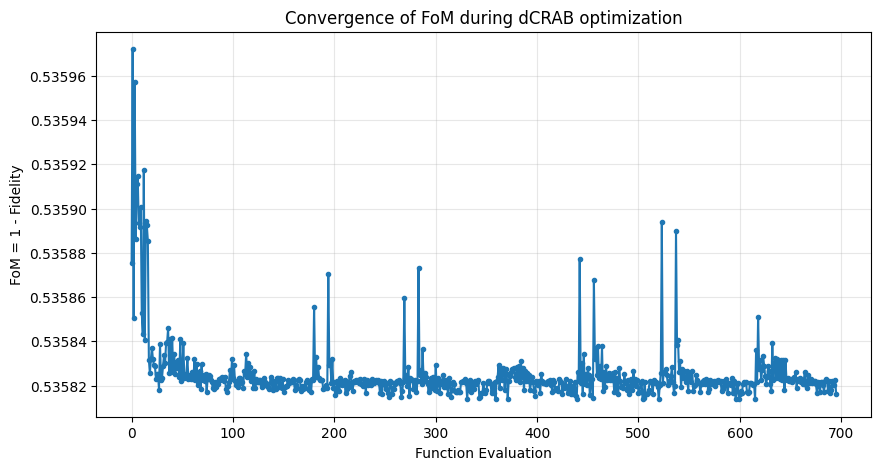

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


opt_alg = optimizer.get_optimization_algorithm()


fom_list = np.array(opt_alg.FoM_list)
N = len(fom_list)

plt.figure(figsize=(10,5))
plt.plot(fom_list, "-o", markersize=3)
plt.xlabel("Function Evaluation")
plt.ylabel("FoM = 1 - Fidelity")
plt.title("Convergence of FoM during dCRAB optimization")
plt.grid(alpha=0.3)
plt.show()


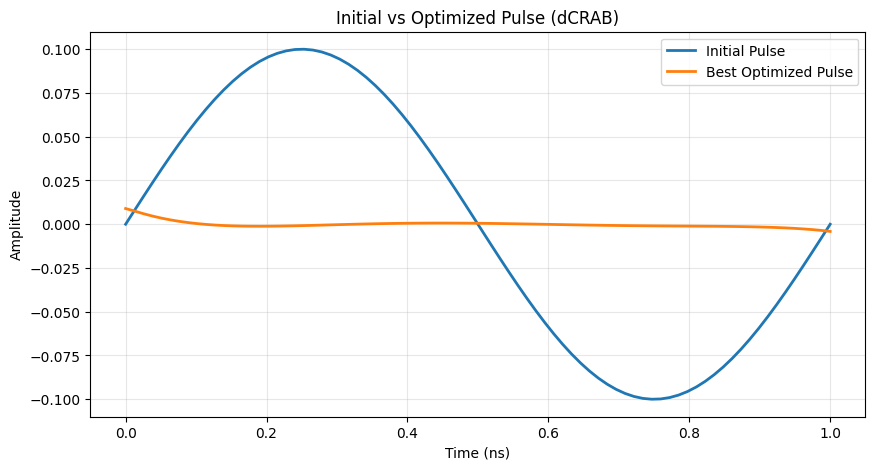

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


best_controls = opt_alg.get_best_controls()
best_pulse = np.array(best_controls["pulses"][0])
time_best = np.array(best_controls["timegrids"][0])


T = time_best[-1]
initial_pulse = 0.1 * np.sin(2 * np.pi * time_best / T)

# Plot comparison
plt.figure(figsize=(10,5))
plt.plot(time_best, initial_pulse, label="Initial Pulse", linewidth=2)
plt.plot(time_best, best_pulse, label="Best Optimized Pulse", linewidth=2)
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.title("Initial vs Optimized Pulse (dCRAB)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
